# Reinforcement Learning: Training a DQN-Agent in playing Atari Carnival

In [1]:
#Packages additionally needed to run the code in a Kaggle Notebook
!pip install gymnasium[accept-rom-license]
!pip install gymnasium[atari]
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446664 sha256=b88e7887a9a076e9203a0df5a4b138149f19adc19d6531c1753b4181207f7143
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the foll

## Creation and Training of the DQN-Agent

The foundation of the code of this notebook origins from https://github.com/SlicerBX/atari-carnival-reinforcement-learning/blob/main/DQN/DQN.py

In [2]:
import random
import gymnasium as gym
import numpy as np
from collections import deque
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Input
from time import time
import datetime
import cv2
import os
from tqdm import tqdm

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

state_size = (96, 80, 1)

class DQN_Agent:
    # Initializes attributes and constructs CNN model and target_model
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=8000)  # Replay memory

        # Hyperparameters
        self.gamma = 0.95  # Discount rate, how much is future reward worth
        self.epsilon = 0.99  # Exploration rate
        self.epsilon_min = 0.1  # Minimal exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.99  # Decay rate for epsilon per episode
        self.update_rate = 4  # Number of steps until updating the target network

        # CNN Hyperparameters
        self.learning_rate = 0.02
        self.loss = tf.compat.v1.losses.huber_loss 
        self.optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=self.learning_rate,
            rho=0.5,  # Parameter to consider historic learning to make training more stable
            momentum=0.1,  # Parameter to stronger update gradients going several episodes into the same direction
            epsilon=0.00001,
            centered=True
        )
# # Alternative optimizer tested in several runs
#         self.optimizer = tf.keras.optimizers.Adam(
#             learning_rate=self.learning_rate,
#             beta_1=0.8,
#             beta_2=0.99,
#             epsilon=1e-07
#         )

        # Construct DQN models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()

    # Constructs CNN
    def _build_model(self):
        model = Sequential()

        model.add(Input(shape=self.state_size))
        # Convolutional Layers
        # The first number is the output depth. The tuples are kernel size.
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', activation='relu'))
        model.add(Conv2D(64, (4, 4), strides=2, padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(Flatten())

        # Fully Connected Layers
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.add(Flatten())
        model.compile(loss=self.loss, optimizer=self.optimizer)
        return model

    # Stores experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Chooses action based on epsilon-greedy policy
    def act(self, state):
        # Random exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        act_values = self.model.predict(state, verbose=0)

        return np.argmax(act_values[0])  # Returns action using policy

    # Trains the model using randomly selected experiences in the replay memory
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)  # Batch size is the return size

        for state, action, reward, next_state, done in minibatch:

            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)))  # TD
            else:
                target = reward

            # Construct the target vector as follows:
            # Use the current model to output the Q-value predictions.
            target_f = self.model.predict(state, verbose=0)  # This constructs our Q value

            # Rewrite the chosen action value with the computed target
            target_f[0][action] = target

            self.model.fit(state, target_f, epochs=1, verbose=0)  # Train model so Q-value match the target function

        #  Simple decay rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Sets the target model parameters to the current model parameters
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

'''Preprocessing: To save on computations by converting RGB-observations into Grayscale'''

# Helpful preprocessing taken from github.com/ageron/tiny-dqn
def process_frame(frame):
    frame_np = np.array(frame[0])  # Convert frame[0] to numpy array

    # Check if frame is grayscale or RGB and convert accordingly
    if len(frame_np.shape) == 2:  # Grayscale image
        img = frame_np
    elif len(frame_np.shape) == 3 and frame_np.shape[2] == 3:
        img = cv2.cvtColor(frame_np, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError("ACHTUNG! Unsupported frame format or number of channels.")

    img = img / 255  # Normalize
    img = cv2.resize(img, state_size[:2])  # Resize the image
    return np.expand_dims(img.reshape(state_size), axis=0)

# Use blending by creating an average image based on past images to transport information about changes over time e.g. movements into the model
def blend_images(images, blend):
    avg_image = np.expand_dims(np.zeros(state_size, np.float64), axis=0)

    for image in images:
        avg_image += image

    if len(images) < blend:
        return avg_image / len(images)
    else:
        return avg_image / blend
    
    
if __name__ == '__main__':
    # Utilize a GPU if one is available
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
        except:
            pass
    
    checkpoint_filepath = './DQN_weights/checkpoint'
    env = gym.make('ALE/Carnival-v5', render_mode=None)  # Disable rendering to save perfomance during training

    action_size = env.action_space.n
    agent = DQN_Agent(state_size, action_size)
    episodes = 400                                               #+++++++++++++++++No of EPISODES++++++++++++++++++++++
    list_of_episode_rewards = []
    list_of_hit_ratios = []
    list_of_actions_taken = []
    batch_size = 12  #Length of the series the model is trained with
    skip_start = 50  
    total_time = 0  # Counter for total number of steps taken
    all_rewards = 0  # Used to compute avg reward over time
    blend = 6  # Number of images to blend
    done = False

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = 'logs/Carnivaldqn/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)

    # An episode is essentially an Epoch.
    for e in tqdm(range(episodes), desc="Episodes"):
        start = time()
        episode_reward = 0
        game_score = 0
        state = process_frame(env.reset())
        images = deque(maxlen=blend)  # Array of images to be blended
        images.append(state)
        done = False
        shots = 1
        hit = 0
        for t in range(1200):
            # Return the avg of the last 4 frames.
            state = blend_images(images, blend)

            # Transition
            action = agent.act(state)
            step_result = env.step(action)
            next_state, reward, done, _ = step_result[:4]
            game_score += reward
            # Detect if the agent selected to shoot
            if action in [1,4,5]:
                shots += 1
            if reward > 0:
                    hit +=1

            hit_ratio = hit/shots
            # Reward the agent exponentially for achieving a high hit ratio
            if reward > 0:
                reward = round(reward * ((4 * hit_ratio - 0.07)**3 + 1), 3)
            # possible extra reward of +1500 over all 1200 steps, rewarding the agent exponentially for surviving longer
            reward += 0.000002605  * t ** 2
            
            # Return the avg of the last 4 frames
            next_state = process_frame(next_state)
            images.append(next_state)
            next_state = blend_images(images, blend)
            
            # Store sequence in replay memory
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            if done:
                break
            # Training the agent´s model with memories, extra criterium with modulo was added to increase episodes. Otherwise timeouts are very likely for training over a lot of episodes
            if (len(agent.memory) > 500) and (t%250==0):
                agent.replay(batch_size)            
            if t % agent.update_rate == 0:
                agent.update_target_model()

        all_rewards += game_score
        list_of_episode_rewards.append(episode_reward)
        list_of_hit_ratios.append(hit_ratio)
        list_of_actions_taken.append(t)
        avg_rewards = np.mean(list_of_episode_rewards[max(0, e - 25):(e + 1)])  # Moving average
        end_time = (time() - start)
        total_time += end_time
        print(
            "episode: {}/{},\t actions_taken: {},\t game score: {},\t reward: {:.2f},\t avg reward: {:.4f},\t hit ratio: {:.3f}%,\t time: {:.2f},\t total time: {:.2f},\t epsilon: {:.4f}".format(
                e + 1, episodes, t, game_score, episode_reward, avg_rewards, hit_ratio * 100, end_time, total_time, agent.epsilon
            )
        )

        with summary_writer.as_default():
            tf.summary.scalar('episode reward', episode_reward, step=e)
            tf.summary.scalar('running avg reward(25)', avg_rewards, step=e)
            tf.summary.scalar('number of steps', t, step=e)
            tf.summary.scalar('Time this episode', end_time, step=e)
        agent.save('/kaggle/working/Gewichte.weights.h5')

    env.close()

2024-07-25 21:37:10.744742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 21:37:10.744921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 21:37:10.926885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 20, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,007,590 (15.29 MB)

 Trainable params: 4,007,590 (15.29 MB)

 Non-trainable params: 0 (0.00 B)

Episodes:   0%|          | 1/400 [00:02<16:36,  2.50s/it]

episode: 1/400,	 actions_taken: 362,	 game score: 1180.0,	 reward: 1263.72,	 avg reward: 1263.7158,	 hit ratio: 8.092%,	 time: 2.42,	 total time: 2.42,	 epsilon: 0.9900


Episodes:   0%|          | 2/400 [00:10<38:06,  5.75s/it]

episode: 2/400,	 actions_taken: 388,	 game score: 940.0,	 reward: 1011.76,	 avg reward: 1137.7357,	 hit ratio: 6.512%,	 time: 7.82,	 total time: 10.25,	 epsilon: 0.9801


Episodes:   1%|          | 3/400 [00:20<51:32,  7.79s/it]

episode: 3/400,	 actions_taken: 459,	 game score: 760.0,	 reward: 851.28,	 avg reward: 1042.2520,	 hit ratio: 5.714%,	 time: 10.03,	 total time: 20.27,	 epsilon: 0.9606


Episodes:   1%|          | 4/400 [00:30<57:10,  8.66s/it]

episode: 4/400,	 actions_taken: 379,	 game score: 320.0,	 reward: 383.46,	 avg reward: 877.5546,	 hit ratio: 6.633%,	 time: 9.84,	 total time: 30.11,	 epsilon: 0.9415


Episodes:   1%|▏         | 5/400 [00:42<1:03:29,  9.64s/it]

episode: 5/400,	 actions_taken: 338,	 game score: 540.0,	 reward: 575.29,	 avg reward: 817.1021,	 hit ratio: 5.143%,	 time: 11.22,	 total time: 41.34,	 epsilon: 0.9227


Episodes:   2%|▏         | 6/400 [00:53<1:06:51, 10.18s/it]

episode: 6/400,	 actions_taken: 331,	 game score: 920.0,	 reward: 955.27,	 avg reward: 840.1299,	 hit ratio: 5.612%,	 time: 11.06,	 total time: 52.40,	 epsilon: 0.9044


Episodes:   2%|▏         | 7/400 [01:05<1:09:53, 10.67s/it]

episode: 7/400,	 actions_taken: 378,	 game score: 400.0,	 reward: 516.87,	 avg reward: 793.9493,	 hit ratio: 5.056%,	 time: 11.52,	 total time: 63.92,	 epsilon: 0.8864


Episodes:   2%|▏         | 8/400 [01:19<1:16:36, 11.73s/it]

episode: 8/400,	 actions_taken: 392,	 game score: 520.0,	 reward: 623.57,	 avg reward: 772.6523,	 hit ratio: 6.135%,	 time: 13.82,	 total time: 77.74,	 epsilon: 0.8687


Episodes:   2%|▏         | 9/400 [01:31<1:17:56, 11.96s/it]

episode: 9/400,	 actions_taken: 308,	 game score: 1200.0,	 reward: 1404.08,	 avg reward: 842.8111,	 hit ratio: 10.370%,	 time: 12.31,	 total time: 90.04,	 epsilon: 0.8515


Episodes:   2%|▎         | 10/400 [01:46<1:23:54, 12.91s/it]

episode: 10/400,	 actions_taken: 466,	 game score: 1000.0,	 reward: 1326.82,	 avg reward: 891.2115,	 hit ratio: 8.333%,	 time: 14.87,	 total time: 104.92,	 epsilon: 0.8345


Episodes:   3%|▎         | 11/400 [02:00<1:26:40, 13.37s/it]

episode: 11/400,	 actions_taken: 400,	 game score: 880.0,	 reward: 956.11,	 avg reward: 897.1116,	 hit ratio: 7.910%,	 time: 14.24,	 total time: 119.16,	 epsilon: 0.8179


Episodes:   3%|▎         | 12/400 [02:15<1:29:25, 13.83s/it]

episode: 12/400,	 actions_taken: 367,	 game score: 540.0,	 reward: 825.92,	 avg reward: 891.1792,	 hit ratio: 7.229%,	 time: 14.71,	 total time: 133.87,	 epsilon: 0.8016


Episodes:   3%|▎         | 13/400 [02:33<1:37:25, 15.10s/it]

episode: 13/400,	 actions_taken: 444,	 game score: 820.0,	 reward: 974.19,	 avg reward: 897.5645,	 hit ratio: 4.240%,	 time: 17.88,	 total time: 151.74,	 epsilon: 0.7857


Episodes:   4%|▎         | 14/400 [02:50<1:40:03, 15.55s/it]

episode: 14/400,	 actions_taken: 431,	 game score: 600.0,	 reward: 681.52,	 avg reward: 882.1324,	 hit ratio: 5.780%,	 time: 16.42,	 total time: 168.17,	 epsilon: 0.7700


Episodes:   4%|▍         | 15/400 [03:04<1:37:49, 15.25s/it]

episode: 15/400,	 actions_taken: 349,	 game score: 840.0,	 reward: 907.13,	 avg reward: 883.7989,	 hit ratio: 6.218%,	 time: 14.37,	 total time: 182.54,	 epsilon: 0.7547


Episodes:   4%|▍         | 16/400 [03:21<1:39:34, 15.56s/it]

episode: 16/400,	 actions_taken: 391,	 game score: 700.0,	 reward: 759.02,	 avg reward: 876.0003,	 hit ratio: 5.306%,	 time: 16.11,	 total time: 198.66,	 epsilon: 0.7397


Episodes:   4%|▍         | 17/400 [03:40<1:46:06, 16.62s/it]

episode: 17/400,	 actions_taken: 471,	 game score: 280.0,	 reward: 391.41,	 avg reward: 847.4950,	 hit ratio: 3.226%,	 time: 18.94,	 total time: 217.60,	 epsilon: 0.7250


Episodes:   4%|▍         | 18/400 [03:59<1:50:17, 17.32s/it]

episode: 18/400,	 actions_taken: 416,	 game score: 580.0,	 reward: 644.13,	 avg reward: 836.1971,	 hit ratio: 4.745%,	 time: 18.79,	 total time: 236.38,	 epsilon: 0.7106


Episodes:   5%|▍         | 19/400 [04:18<1:53:31, 17.88s/it]

episode: 19/400,	 actions_taken: 436,	 game score: 500.0,	 reward: 654.31,	 avg reward: 826.6239,	 hit ratio: 6.962%,	 time: 18.99,	 total time: 255.38,	 epsilon: 0.6964


Episodes:   5%|▌         | 20/400 [04:38<1:56:24, 18.38s/it]

episode: 20/400,	 actions_taken: 383,	 game score: 1140.0,	 reward: 1198.25,	 avg reward: 845.2053,	 hit ratio: 5.364%,	 time: 19.38,	 total time: 274.76,	 epsilon: 0.6826


Episodes:   5%|▌         | 21/400 [04:58<2:00:10, 19.03s/it]

episode: 21/400,	 actions_taken: 416,	 game score: 440.0,	 reward: 516.27,	 avg reward: 829.5419,	 hit ratio: 5.208%,	 time: 20.36,	 total time: 295.12,	 epsilon: 0.6690


Episodes:   6%|▌         | 22/400 [05:19<2:02:40, 19.47s/it]

episode: 22/400,	 actions_taken: 426,	 game score: 420.0,	 reward: 492.99,	 avg reward: 814.2440,	 hit ratio: 6.667%,	 time: 20.34,	 total time: 315.46,	 epsilon: 0.6557


Episodes:   6%|▌         | 23/400 [05:38<2:02:25, 19.48s/it]

episode: 23/400,	 actions_taken: 385,	 game score: 580.0,	 reward: 656.93,	 avg reward: 807.4042,	 hit ratio: 7.143%,	 time: 19.35,	 total time: 334.81,	 epsilon: 0.6426


Episodes:   6%|▌         | 24/400 [05:59<2:05:32, 20.03s/it]

episode: 24/400,	 actions_taken: 401,	 game score: 440.0,	 reward: 497.99,	 avg reward: 794.5118,	 hit ratio: 3.788%,	 time: 21.14,	 total time: 355.95,	 epsilon: 0.6298


Episodes:   6%|▋         | 25/400 [06:21<2:08:01, 20.48s/it]

episode: 25/400,	 actions_taken: 400,	 game score: 920.0,	 reward: 1096.69,	 avg reward: 806.5988,	 hit ratio: 11.570%,	 time: 21.37,	 total time: 377.32,	 epsilon: 0.6173


Episodes:   6%|▋         | 26/400 [06:54<2:31:32, 24.31s/it]

episode: 26/400,	 actions_taken: 582,	 game score: 780.0,	 reward: 2093.56,	 avg reward: 856.0972,	 hit ratio: 10.056%,	 time: 33.07,	 total time: 410.39,	 epsilon: 0.5990


Episodes:   7%|▋         | 27/400 [07:15<2:24:06, 23.18s/it]

episode: 27/400,	 actions_taken: 363,	 game score: 1040.0,	 reward: 1257.21,	 avg reward: 855.8469,	 hit ratio: 8.805%,	 time: 20.37,	 total time: 430.76,	 epsilon: 0.5870


Episodes:   7%|▋         | 28/400 [07:37<2:21:28, 22.82s/it]

episode: 28/400,	 actions_taken: 406,	 game score: 880.0,	 reward: 963.68,	 avg reward: 853.9979,	 hit ratio: 4.663%,	 time: 21.80,	 total time: 452.56,	 epsilon: 0.5754


Episodes:   7%|▋         | 29/400 [07:58<2:18:21, 22.38s/it]

episode: 29/400,	 actions_taken: 370,	 game score: 420.0,	 reward: 533.00,	 avg reward: 841.7561,	 hit ratio: 5.988%,	 time: 21.16,	 total time: 473.72,	 epsilon: 0.5639


Episodes:   8%|▊         | 30/400 [08:19<2:16:14, 22.09s/it]

episode: 30/400,	 actions_taken: 331,	 game score: 540.0,	 reward: 644.12,	 avg reward: 851.7814,	 hit ratio: 12.222%,	 time: 21.27,	 total time: 494.99,	 epsilon: 0.5527


Episodes:   8%|▊         | 31/400 [08:43<2:18:11, 22.47s/it]

episode: 31/400,	 actions_taken: 372,	 game score: 440.0,	 reward: 586.89,	 avg reward: 852.2274,	 hit ratio: 9.434%,	 time: 23.18,	 total time: 518.16,	 epsilon: 0.5417


Episodes:   8%|▊         | 32/400 [09:06<2:19:39, 22.77s/it]

episode: 32/400,	 actions_taken: 390,	 game score: 420.0,	 reward: 484.09,	 avg reward: 834.1053,	 hit ratio: 8.850%,	 time: 23.30,	 total time: 541.46,	 epsilon: 0.5309


Episodes:   8%|▊         | 33/400 [09:40<2:39:35, 26.09s/it]

episode: 33/400,	 actions_taken: 532,	 game score: 1200.0,	 reward: 1334.80,	 avg reward: 865.5644,	 hit ratio: 3.655%,	 time: 33.67,	 total time: 575.13,	 epsilon: 0.5151


Episodes:   8%|▊         | 34/400 [10:08<2:42:06, 26.58s/it]

episode: 34/400,	 actions_taken: 465,	 game score: 480.0,	 reward: 569.92,	 avg reward: 863.5008,	 hit ratio: 4.490%,	 time: 27.53,	 total time: 602.66,	 epsilon: 0.5049


Episodes:   9%|▉         | 35/400 [10:33<2:38:16, 26.02s/it]

episode: 35/400,	 actions_taken: 392,	 game score: 1080.0,	 reward: 1135.40,	 avg reward: 853.1667,	 hit ratio: 4.348%,	 time: 24.54,	 total time: 627.20,	 epsilon: 0.4948


Episodes:   9%|▉         | 36/400 [10:59<2:38:34, 26.14s/it]

episode: 36/400,	 actions_taken: 436,	 game score: 740.0,	 reward: 842.82,	 avg reward: 834.5516,	 hit ratio: 8.696%,	 time: 26.25,	 total time: 653.46,	 epsilon: 0.4850


Episodes:   9%|▉         | 37/400 [11:28<2:42:55, 26.93s/it]

episode: 37/400,	 actions_taken: 473,	 game score: 400.0,	 reward: 493.26,	 avg reward: 816.7498,	 hit ratio: 2.459%,	 time: 28.58,	 total time: 682.04,	 epsilon: 0.4753


Episodes:  10%|▉         | 38/400 [11:57<2:46:03, 27.52s/it]

episode: 38/400,	 actions_taken: 431,	 game score: 500.0,	 reward: 729.25,	 avg reward: 813.0314,	 hit ratio: 6.180%,	 time: 28.74,	 total time: 710.78,	 epsilon: 0.4659


Episodes:  10%|▉         | 39/400 [12:35<3:04:30, 30.67s/it]

episode: 39/400,	 actions_taken: 562,	 game score: 660.0,	 reward: 1151.96,	 avg reward: 819.8689,	 hit ratio: 14.783%,	 time: 37.83,	 total time: 748.61,	 epsilon: 0.4520


Episodes:  10%|█         | 40/400 [13:06<3:06:05, 31.02s/it]

episode: 40/400,	 actions_taken: 477,	 game score: 520.0,	 reward: 805.68,	 avg reward: 824.6443,	 hit ratio: 10.280%,	 time: 31.66,	 total time: 780.27,	 epsilon: 0.4430


Episodes:  10%|█         | 41/400 [13:35<3:01:34, 30.35s/it]

episode: 41/400,	 actions_taken: 460,	 game score: 940.0,	 reward: 1319.83,	 avg reward: 840.5174,	 hit ratio: 6.818%,	 time: 28.61,	 total time: 808.88,	 epsilon: 0.4342


Episodes:  10%|█         | 42/400 [14:04<2:57:46, 29.79s/it]

episode: 42/400,	 actions_taken: 435,	 game score: 1040.0,	 reward: 1116.63,	 avg reward: 854.2717,	 hit ratio: 3.652%,	 time: 28.34,	 total time: 837.22,	 epsilon: 0.4256


Episodes:  11%|█         | 43/400 [14:41<3:10:59, 32.10s/it]

episode: 43/400,	 actions_taken: 515,	 game score: 1180.0,	 reward: 1318.23,	 avg reward: 889.9186,	 hit ratio: 5.282%,	 time: 37.31,	 total time: 874.52,	 epsilon: 0.4129


Episodes:  11%|█         | 44/400 [15:14<3:12:00, 32.36s/it]

episode: 44/400,	 actions_taken: 467,	 game score: 1080.0,	 reward: 1179.73,	 avg reward: 910.5187,	 hit ratio: 3.714%,	 time: 32.80,	 total time: 907.33,	 epsilon: 0.4047


Episodes:  11%|█▏        | 45/400 [15:47<3:12:25, 32.52s/it]

episode: 45/400,	 actions_taken: 451,	 game score: 440.0,	 reward: 550.91,	 avg reward: 906.5418,	 hit ratio: 4.369%,	 time: 32.72,	 total time: 940.05,	 epsilon: 0.3967


Episodes:  12%|█▏        | 46/400 [17:02<4:27:33, 45.35s/it]

episode: 46/400,	 actions_taken: 1058,	 game score: 1380.0,	 reward: 3071.96,	 avg reward: 978.6074,	 hit ratio: 4.673%,	 time: 75.10,	 total time: 1015.15,	 epsilon: 0.3772


Episodes:  12%|█▏        | 47/400 [17:43<4:18:11, 43.88s/it]

episode: 47/400,	 actions_taken: 516,	 game score: 920.0,	 reward: 1064.61,	 avg reward: 999.6971,	 hit ratio: 3.623%,	 time: 40.29,	 total time: 1055.44,	 epsilon: 0.3660


Episodes:  12%|█▏        | 48/400 [18:15<3:57:15, 40.44s/it]

episode: 48/400,	 actions_taken: 431,	 game score: 800.0,	 reward: 870.25,	 avg reward: 1014.2071,	 hit ratio: 3.073%,	 time: 32.24,	 total time: 1087.68,	 epsilon: 0.3587


Episodes:  12%|█▏        | 49/400 [18:48<3:42:42, 38.07s/it]

episode: 49/400,	 actions_taken: 421,	 game score: 480.0,	 reward: 545.54,	 avg reward: 1009.9228,	 hit ratio: 3.152%,	 time: 32.36,	 total time: 1120.04,	 epsilon: 0.3516


Episodes:  12%|█▎        | 50/400 [19:28<3:45:22, 38.64s/it]

episode: 50/400,	 actions_taken: 501,	 game score: 480.0,	 reward: 665.39,	 avg reward: 1016.3612,	 hit ratio: 12.222%,	 time: 39.78,	 total time: 1159.82,	 epsilon: 0.3412


Episodes:  13%|█▎        | 51/400 [19:54<3:23:04, 34.91s/it]

episode: 51/400,	 actions_taken: 328,	 game score: 500.0,	 reward: 878.19,	 avg reward: 1007.9574,	 hit ratio: 15.714%,	 time: 26.03,	 total time: 1185.85,	 epsilon: 0.3344


Episodes:  13%|█▎        | 52/400 [20:30<3:23:57, 35.17s/it]

episode: 52/400,	 actions_taken: 459,	 game score: 860.0,	 reward: 947.63,	 avg reward: 963.8832,	 hit ratio: 6.557%,	 time: 35.57,	 total time: 1221.42,	 epsilon: 0.3277


Episodes:  13%|█▎        | 53/400 [21:01<3:16:52, 34.04s/it]

episode: 53/400,	 actions_taken: 416,	 game score: 780.0,	 reward: 842.97,	 avg reward: 947.9508,	 hit ratio: 2.874%,	 time: 31.22,	 total time: 1252.63,	 epsilon: 0.3212
episode: 54/400,	 actions_taken: 563,	 game score: 1020.0,	 reward: 1349.67,	 avg reward: 962.7964,	 hit ratio: 6.538%,	 time: 46.85,	 total time: 1299.49,	 epsilon: 0.3117


Episodes:  14%|█▎        | 54/400 [21:48<3:38:49, 37.95s/it]

episode: 55/400,	 actions_taken: 602,	 game score: 920.0,	 reward: 1396.19,	 avg reward: 995.9963,	 hit ratio: 4.559%,	 time: 50.73,	 total time: 1350.22,	 epsilon: 0.3024


Episodes:  14%|█▍        | 56/400 [23:16<3:50:28, 40.20s/it]

episode: 56/400,	 actions_taken: 426,	 game score: 300.0,	 reward: 370.10,	 avg reward: 985.4571,	 hit ratio: 4.348%,	 time: 36.16,	 total time: 1386.38,	 epsilon: 0.2964
episode: 57/400,	 actions_taken: 401,	 game score: 540.0,	 reward: 604.50,	 avg reward: 986.1344,	 hit ratio: 5.195%,	 time: 35.21,	 total time: 1421.59,	 epsilon: 0.2905


Episodes:  14%|█▍        | 57/400 [23:51<3:41:35, 38.76s/it]

episode: 58/400,	 actions_taken: 654,	 game score: 960.0,	 reward: 1784.81,	 avg reward: 1036.1621,	 hit ratio: 6.667%,	 time: 57.30,	 total time: 1478.89,	 epsilon: 0.2819


Episodes:  14%|█▍        | 58/400 [24:48<4:13:00, 44.39s/it]

episode: 59/400,	 actions_taken: 436,	 game score: 400.0,	 reward: 634.64,	 avg reward: 1009.2327,	 hit ratio: 15.254%,	 time: 41.93,	 total time: 1520.82,	 epsilon: 0.2763


Episodes:  15%|█▍        | 59/400 [25:31<4:08:26, 43.71s/it]

episode: 60/400,	 actions_taken: 508,	 game score: 820.0,	 reward: 935.75,	 avg reward: 1023.3032,	 hit ratio: 3.521%,	 time: 44.64,	 total time: 1565.46,	 epsilon: 0.2680


Episodes:  15%|█▌        | 61/400 [27:05<4:17:30, 45.58s/it]

episode: 61/400,	 actions_taken: 593,	 game score: 920.0,	 reward: 1103.56,	 avg reward: 1022.0789,	 hit ratio: 5.776%,	 time: 48.94,	 total time: 1614.40,	 epsilon: 0.2601


Episodes:  16%|█▌        | 62/400 [27:50<4:16:57, 45.61s/it]

episode: 62/400,	 actions_taken: 530,	 game score: 780.0,	 reward: 1091.78,	 avg reward: 1031.6541,	 hit ratio: 3.147%,	 time: 45.50,	 total time: 1659.91,	 epsilon: 0.2524


Episodes:  16%|█▌        | 63/400 [28:36<4:16:57, 45.75s/it]

episode: 63/400,	 actions_taken: 523,	 game score: 340.0,	 reward: 464.69,	 avg reward: 1030.5551,	 hit ratio: 2.483%,	 time: 45.87,	 total time: 1705.78,	 epsilon: 0.2449


Episodes:  16%|█▌        | 64/400 [29:23<4:17:05, 45.91s/it]

episode: 64/400,	 actions_taken: 526,	 game score: 580.0,	 reward: 707.60,	 avg reward: 1029.7228,	 hit ratio: 2.101%,	 time: 46.08,	 total time: 1751.86,	 epsilon: 0.2376


Episodes:  16%|█▋        | 65/400 [30:09<4:17:21, 46.09s/it]

episode: 65/400,	 actions_taken: 527,	 game score: 720.0,	 reward: 847.65,	 avg reward: 1018.0184,	 hit ratio: 2.928%,	 time: 46.33,	 total time: 1798.19,	 epsilon: 0.2305
episode: 66/400,	 actions_taken: 801,	 game score: 560.0,	 reward: 1007.38,	 avg reward: 1025.7761,	 hit ratio: 4.167%,	 time: 73.06,	 total time: 1871.25,	 epsilon: 0.2215


Episodes:  17%|█▋        | 67/400 [32:12<4:53:37, 52.90s/it]

episode: 67/400,	 actions_taken: 560,	 game score: 480.0,	 reward: 1017.17,	 avg reward: 1014.1354,	 hit ratio: 10.784%,	 time: 49.58,	 total time: 1920.83,	 epsilon: 0.2149


Episodes:  17%|█▋        | 68/400 [32:52<4:31:19, 49.03s/it]

episode: 68/400,	 actions_taken: 459,	 game score: 260.0,	 reward: 344.24,	 avg reward: 984.4282,	 hit ratio: 1.446%,	 time: 39.81,	 total time: 1960.63,	 epsilon: 0.2106
episode: 69/400,	 actions_taken: 460,	 game score: 340.0,	 reward: 424.84,	 avg reward: 950.0671,	 hit ratio: 3.320%,	 time: 39.59,	 total time: 2000.23,	 epsilon: 0.2064


Episodes:  17%|█▋        | 69/400 [33:32<4:15:13, 46.26s/it]

episode: 70/400,	 actions_taken: 501,	 game score: 620.0,	 reward: 1039.99,	 avg reward: 944.6925,	 hit ratio: 16.949%,	 time: 44.95,	 total time: 2045.18,	 epsilon: 0.2003


Episodes:  18%|█▊        | 71/400 [35:09<4:20:50, 47.57s/it]

episode: 71/400,	 actions_taken: 560,	 game score: 400.0,	 reward: 553.03,	 avg reward: 944.7742,	 hit ratio: 2.532%,	 time: 51.18,	 total time: 2096.36,	 epsilon: 0.1943
episode: 72/400,	 actions_taken: 540,	 game score: 480.0,	 reward: 1286.91,	 avg reward: 876.1187,	 hit ratio: 19.643%,	 time: 50.13,	 total time: 2146.49,	 epsilon: 0.1886


Episodes:  18%|█▊        | 72/400 [35:59<4:24:34, 48.40s/it]

episode: 73/400,	 actions_taken: 664,	 game score: 760.0,	 reward: 1014.91,	 avg reward: 874.2072,	 hit ratio: 1.669%,	 time: 59.96,	 total time: 2206.45,	 epsilon: 0.1830


Episodes:  18%|█▊        | 74/400 [37:53<4:44:58, 52.45s/it]

episode: 74/400,	 actions_taken: 529,	 game score: 780.0,	 reward: 909.09,	 avg reward: 875.7013,	 hit ratio: 1.931%,	 time: 53.46,	 total time: 2259.91,	 epsilon: 0.1775
episode: 75/400,	 actions_taken: 632,	 game score: 380.0,	 reward: 599.74,	 avg reward: 877.7858,	 hit ratio: 1.915%,	 time: 55.95,	 total time: 2315.87,	 epsilon: 0.1722


Episodes:  19%|█▉        | 76/400 [39:46<4:55:29, 54.72s/it]

episode: 76/400,	 actions_taken: 656,	 game score: 440.0,	 reward: 1002.64,	 avg reward: 890.7572,	 hit ratio: 12.963%,	 time: 57.23,	 total time: 2373.10,	 epsilon: 0.1671


Episodes:  19%|█▉        | 77/400 [40:36<4:46:40, 53.25s/it]

episode: 77/400,	 actions_taken: 518,	 game score: 800.0,	 reward: 2001.11,	 avg reward: 933.9467,	 hit ratio: 3.659%,	 time: 49.63,	 total time: 2422.73,	 epsilon: 0.1622
episode: 78/400,	 actions_taken: 555,	 game score: 680.0,	 reward: 1498.00,	 avg reward: 955.1150,	 hit ratio: 3.934%,	 time: 50.31,	 total time: 2473.04,	 epsilon: 0.1574


Episodes:  20%|█▉        | 79/400 [42:23<4:46:33, 53.56s/it]

episode: 79/400,	 actions_taken: 642,	 game score: 780.0,	 reward: 1010.63,	 avg reward: 961.5635,	 hit ratio: 2.017%,	 time: 56.00,	 total time: 2529.03,	 epsilon: 0.1527


Episodes:  20%|██        | 80/400 [43:21<4:52:27, 54.84s/it]

episode: 80/400,	 actions_taken: 645,	 game score: 500.0,	 reward: 735.53,	 avg reward: 937.9426,	 hit ratio: 3.191%,	 time: 57.61,	 total time: 2586.64,	 epsilon: 0.1481


Episodes:  20%|██        | 81/400 [44:40<5:30:30, 62.17s/it]

episode: 81/400,	 actions_taken: 855,	 game score: 820.0,	 reward: 2074.24,	 avg reward: 964.0215,	 hit ratio: 9.697%,	 time: 79.08,	 total time: 2665.72,	 epsilon: 0.1423


Episodes:  20%|██        | 82/400 [45:34<5:17:21, 59.88s/it]

episode: 82/400,	 actions_taken: 622,	 game score: 580.0,	 reward: 1788.32,	 avg reward: 1018.5685,	 hit ratio: 23.077%,	 time: 54.35,	 total time: 2720.07,	 epsilon: 0.1381
episode: 83/400,	 actions_taken: 555,	 game score: 660.0,	 reward: 808.84,	 avg reward: 1026.4280,	 hit ratio: 1.737%,	 time: 52.22,	 total time: 2772.29,	 epsilon: 0.1340


Episodes:  21%|██        | 84/400 [47:17<4:51:34, 55.36s/it]

episode: 84/400,	 actions_taken: 525,	 game score: 280.0,	 reward: 406.02,	 avg reward: 973.3976,	 hit ratio: 2.847%,	 time: 49.85,	 total time: 2822.14,	 epsilon: 0.1300


Episodes:  21%|██▏       | 85/400 [48:14<4:53:20, 55.87s/it]

episode: 85/400,	 actions_taken: 631,	 game score: 840.0,	 reward: 3231.41,	 avg reward: 1073.2736,	 hit ratio: 7.975%,	 time: 56.89,	 total time: 2879.03,	 epsilon: 0.1261


Episodes:  22%|██▏       | 86/400 [49:06<4:46:47, 54.80s/it]

episode: 86/400,	 actions_taken: 565,	 game score: 260.0,	 reward: 489.77,	 avg reward: 1056.1202,	 hit ratio: 2.353%,	 time: 52.12,	 total time: 2931.14,	 epsilon: 0.1224


Episodes:  22%|██▏       | 87/400 [50:04<4:51:01, 55.79s/it]

episode: 87/400,	 actions_taken: 602,	 game score: 320.0,	 reward: 510.07,	 avg reward: 1033.2935,	 hit ratio: 1.989%,	 time: 57.90,	 total time: 2989.04,	 epsilon: 0.1188


Episodes:  22%|██▏       | 88/400 [50:58<4:47:24, 55.27s/it]

episode: 88/400,	 actions_taken: 565,	 game score: 740.0,	 reward: 2256.84,	 avg reward: 1078.1037,	 hit ratio: 27.273%,	 time: 53.86,	 total time: 3042.91,	 epsilon: 0.1152
episode: 89/400,	 actions_taken: 699,	 game score: 420.0,	 reward: 717.22,	 avg reward: 1087.8164,	 hit ratio: 1.520%,	 time: 63.16,	 total time: 3106.07,	 epsilon: 0.1118


Episodes:  22%|██▏       | 89/400 [52:02<4:59:04, 57.70s/it]

episode: 90/400,	 actions_taken: 560,	 game score: 340.0,	 reward: 492.91,	 avg reward: 1079.5588,	 hit ratio: 2.251%,	 time: 55.73,	 total time: 3161.79,	 epsilon: 0.1085


Episodes:  22%|██▎       | 90/400 [52:58<4:55:23, 57.17s/it]

episode: 91/400,	 actions_taken: 565,	 game score: 220.0,	 reward: 397.63,	 avg reward: 1062.2502,	 hit ratio: 12.821%,	 time: 52.73,	 total time: 3214.53,	 epsilon: 0.1053


Episodes:  23%|██▎       | 92/400 [55:06<5:17:31, 61.86s/it]

episode: 92/400,	 actions_taken: 855,	 game score: 900.0,	 reward: 2270.54,	 avg reward: 1110.8336,	 hit ratio: 3.901%,	 time: 75.55,	 total time: 3290.08,	 epsilon: 0.1011


Episodes:  23%|██▎       | 93/400 [56:34<5:56:04, 69.59s/it]

episode: 93/400,	 actions_taken: 931,	 game score: 740.0,	 reward: 1441.83,	 avg reward: 1127.1663,	 hit ratio: 1.772%,	 time: 87.44,	 total time: 3377.52,	 epsilon: 0.0991
episode: 94/400,	 actions_taken: 751,	 game score: 520.0,	 reward: 888.53,	 avg reward: 1148.1004,	 hit ratio: 2.033%,	 time: 73.32,	 total time: 3450.84,	 epsilon: 0.0991


Episodes:  24%|██▍       | 95/400 [59:15<6:24:36, 75.66s/it]

episode: 95/400,	 actions_taken: 916,	 game score: 540.0,	 reward: 1502.28,	 avg reward: 1189.5401,	 hit ratio: 2.414%,	 time: 86.86,	 total time: 3537.70,	 epsilon: 0.0991


Episodes:  24%|██▍       | 96/400 [1:00:15<5:59:26, 70.94s/it]

episode: 96/400,	 actions_taken: 667,	 game score: 300.0,	 reward: 558.62,	 avg reward: 1171.0258,	 hit ratio: 1.990%,	 time: 59.74,	 total time: 3597.43,	 epsilon: 0.0991
episode: 97/400,	 actions_taken: 1010,	 game score: 720.0,	 reward: 1809.28,	 avg reward: 1219.3432,	 hit ratio: 5.000%,	 time: 95.61,	 total time: 3693.04,	 epsilon: 0.0991


Episodes:  24%|██▍       | 97/400 [1:01:50<6:35:56, 78.41s/it]

episode: 98/400,	 actions_taken: 555,	 game score: 200.0,	 reward: 348.84,	 avg reward: 1183.2634,	 hit ratio: 1.984%,	 time: 53.18,	 total time: 3746.22,	 epsilon: 0.0991


Episodes:  24%|██▍       | 98/400 [1:02:44<5:56:53, 70.91s/it]

episode: 99/400,	 actions_taken: 1029,	 game score: 0.0,	 reward: 947.51,	 avg reward: 1180.6713,	 hit ratio: 1.873%,	 time: 99.08,	 total time: 3845.29,	 epsilon: 0.0991


Episodes:  25%|██▌       | 100/400 [1:05:20<6:03:08, 72.63s/it]

episode: 100/400,	 actions_taken: 586,	 game score: 680.0,	 reward: 855.60,	 avg reward: 1178.6139,	 hit ratio: 1.455%,	 time: 56.59,	 total time: 3901.89,	 epsilon: 0.0991
episode: 101/400,	 actions_taken: 672,	 game score: 380.0,	 reward: 644.12,	 avg reward: 1180.3211,	 hit ratio: 2.143%,	 time: 63.61,	 total time: 3965.49,	 epsilon: 0.0991


Episodes:  25%|██▌       | 101/400 [1:06:24<5:48:45, 69.98s/it]

episode: 102/400,	 actions_taken: 575,	 game score: 320.0,	 reward: 485.86,	 avg reward: 1160.4447,	 hit ratio: 1.457%,	 time: 54.03,	 total time: 4019.52,	 epsilon: 0.0991


Episodes:  26%|██▌       | 103/400 [1:08:20<5:18:51, 64.42s/it]

episode: 103/400,	 actions_taken: 678,	 game score: 380.0,	 reward: 852.24,	 avg reward: 1116.2572,	 hit ratio: 2.195%,	 time: 62.25,	 total time: 4081.77,	 epsilon: 0.0991


Episodes:  26%|██▌       | 104/400 [1:09:34<5:30:50, 67.06s/it]

episode: 104/400,	 actions_taken: 810,	 game score: 500.0,	 reward: 964.40,	 avg reward: 1095.7341,	 hit ratio: 2.424%,	 time: 73.04,	 total time: 4154.82,	 epsilon: 0.0991


Episodes:  26%|██▋       | 105/400 [1:10:26<5:08:34, 62.76s/it]

episode: 105/400,	 actions_taken: 545,	 game score: 260.0,	 reward: 405.95,	 avg reward: 1072.4772,	 hit ratio: 2.390%,	 time: 52.53,	 total time: 4207.35,	 epsilon: 0.0991


Episodes:  26%|██▋       | 106/400 [1:11:44<5:28:48, 67.10s/it]

episode: 106/400,	 actions_taken: 821,	 game score: 420.0,	 reward: 1120.51,	 avg reward: 1087.2842,	 hit ratio: 1.630%,	 time: 77.04,	 total time: 4284.39,	 epsilon: 0.0991


Episodes:  27%|██▋       | 107/400 [1:12:34<5:02:44, 61.99s/it]

episode: 107/400,	 actions_taken: 541,	 game score: 800.0,	 reward: 937.87,	 avg reward: 1043.5776,	 hit ratio: 1.772%,	 time: 49.88,	 total time: 4334.26,	 epsilon: 0.0991


Episodes:  27%|██▋       | 108/400 [1:13:27<4:49:09, 59.42s/it]

episode: 108/400,	 actions_taken: 550,	 game score: 360.0,	 reward: 504.87,	 avg reward: 994.2138,	 hit ratio: 1.705%,	 time: 53.21,	 total time: 4387.48,	 epsilon: 0.0991


Episodes:  27%|██▋       | 109/400 [1:14:06<4:18:53, 53.38s/it]

episode: 109/400,	 actions_taken: 442,	 game score: 460.0,	 reward: 535.31,	 avg reward: 983.6932,	 hit ratio: 2.153%,	 time: 39.09,	 total time: 4426.57,	 epsilon: 0.0991


Episodes:  28%|██▊       | 110/400 [1:14:58<4:15:50, 52.93s/it]

episode: 110/400,	 actions_taken: 540,	 game score: 320.0,	 reward: 457.12,	 avg reward: 985.6582,	 hit ratio: 1.550%,	 time: 51.69,	 total time: 4478.26,	 epsilon: 0.0991
episode: 111/400,	 actions_taken: 575,	 game score: 480.0,	 reward: 646.71,	 avg reward: 886.2464,	 hit ratio: 3.150%,	 time: 52.00,	 total time: 4530.26,	 epsilon: 0.0991


Episodes:  28%|██▊       | 112/400 [1:17:18<5:03:39, 63.26s/it]

episode: 112/400,	 actions_taken: 931,	 game score: 700.0,	 reward: 1402.78,	 avg reward: 921.3624,	 hit ratio: 2.444%,	 time: 87.68,	 total time: 4617.94,	 epsilon: 0.0991


Episodes:  28%|██▊       | 113/400 [1:18:47<5:38:45, 70.82s/it]

episode: 113/400,	 actions_taken: 945,	 game score: 260.0,	 reward: 993.96,	 avg reward: 939.9738,	 hit ratio: 1.198%,	 time: 88.26,	 total time: 4706.20,	 epsilon: 0.0991
episode: 114/400,	 actions_taken: 575,	 game score: 340.0,	 reward: 704.67,	 avg reward: 880.2749,	 hit ratio: 3.125%,	 time: 57.15,	 total time: 4763.35,	 epsilon: 0.0991


Episodes:  28%|██▊       | 114/400 [1:19:44<5:18:19, 66.78s/it]

episode: 115/400,	 actions_taken: 540,	 game score: 260.0,	 reward: 1310.39,	 avg reward: 903.0889,	 hit ratio: 11.111%,	 time: 51.58,	 total time: 4814.93,	 epsilon: 0.0991


Episodes:  29%|██▉       | 115/400 [1:20:36<4:55:51, 62.29s/it]

episode: 116/400,	 actions_taken: 693,	 game score: 200.0,	 reward: 549.24,	 avg reward: 905.2554,	 hit ratio: 0.907%,	 time: 63.25,	 total time: 4878.18,	 epsilon: 0.0991


Episodes:  29%|██▉       | 117/400 [1:22:38<4:50:06, 61.51s/it]

episode: 117/400,	 actions_taken: 626,	 game score: 300.0,	 reward: 1217.67,	 avg reward: 936.7956,	 hit ratio: 2.362%,	 time: 58.65,	 total time: 4936.83,	 epsilon: 0.0991


Episodes:  30%|██▉       | 118/400 [1:23:33<4:39:23, 59.44s/it]

episode: 118/400,	 actions_taken: 565,	 game score: 100.0,	 reward: 257.02,	 avg reward: 859.3524,	 hit ratio: 0.611%,	 time: 54.46,	 total time: 4991.29,	 epsilon: 0.0991


Episodes:  30%|██▉       | 119/400 [1:25:10<5:31:03, 70.69s/it]

episode: 119/400,	 actions_taken: 1036,	 game score: 920.0,	 reward: 1887.75,	 avg reward: 876.5035,	 hit ratio: 3.043%,	 time: 96.74,	 total time: 5088.04,	 epsilon: 0.0991


Episodes:  30%|███       | 120/400 [1:26:09<5:13:06, 67.09s/it]

episode: 120/400,	 actions_taken: 590,	 game score: 200.0,	 reward: 378.79,	 avg reward: 856.8981,	 hit ratio: 1.232%,	 time: 58.53,	 total time: 5146.56,	 epsilon: 0.0991


Episodes:  30%|███       | 121/400 [1:26:54<4:42:28, 60.75s/it]

episode: 121/400,	 actions_taken: 492,	 game score: 800.0,	 reward: 1420.96,	 avg reward: 853.7706,	 hit ratio: 4.583%,	 time: 45.74,	 total time: 5192.31,	 epsilon: 0.0991


Episodes:  30%|███       | 122/400 [1:27:49<4:32:54, 58.90s/it]

episode: 122/400,	 actions_taken: 550,	 game score: 320.0,	 reward: 570.46,	 avg reward: 854.2257,	 hit ratio: 2.373%,	 time: 54.41,	 total time: 5246.72,	 epsilon: 0.0991
episode: 123/400,	 actions_taken: 587,	 game score: 320.0,	 reward: 866.66,	 avg reward: 817.9711,	 hit ratio: 6.542%,	 time: 58.36,	 total time: 5305.08,	 epsilon: 0.0991


Episodes:  31%|███       | 123/400 [1:28:48<4:31:28, 58.80s/it]

episode: 124/400,	 actions_taken: 613,	 game score: 300.0,	 reward: 500.50,	 avg reward: 823.8043,	 hit ratio: 2.632%,	 time: 57.86,	 total time: 5362.94,	 epsilon: 0.0991


Episodes:  31%|███▏      | 125/400 [1:30:37<4:18:56, 56.50s/it]

episode: 125/400,	 actions_taken: 535,	 game score: 400.0,	 reward: 534.20,	 avg reward: 807.9077,	 hit ratio: 3.614%,	 time: 51.43,	 total time: 5414.37,	 epsilon: 0.0991


Episodes:  32%|███▏      | 126/400 [1:31:31<4:14:38, 55.76s/it]

episode: 126/400,	 actions_taken: 555,	 game score: 320.0,	 reward: 893.06,	 avg reward: 809.3486,	 hit ratio: 8.451%,	 time: 53.88,	 total time: 5468.25,	 epsilon: 0.0991


Episodes:  32%|███▏      | 127/400 [1:32:26<4:12:35, 55.51s/it]

episode: 127/400,	 actions_taken: 589,	 game score: 340.0,	 reward: 517.89,	 avg reward: 804.4934,	 hit ratio: 2.662%,	 time: 54.75,	 total time: 5523.00,	 epsilon: 0.0991


Episodes:  32%|███▏      | 128/400 [1:33:22<4:12:05, 55.61s/it]

episode: 128/400,	 actions_taken: 608,	 game score: 420.0,	 reward: 1831.28,	 avg reward: 856.2404,	 hit ratio: 27.027%,	 time: 55.65,	 total time: 5578.65,	 epsilon: 0.0991
episode: 129/400,	 actions_taken: 545,	 game score: 360.0,	 reward: 500.95,	 avg reward: 842.7292,	 hit ratio: 1.471%,	 time: 53.28,	 total time: 5631.93,	 epsilon: 0.0991


Episodes:  32%|███▏      | 129/400 [1:34:16<4:08:19, 54.98s/it]

episode: 130/400,	 actions_taken: 857,	 game score: 420.0,	 reward: 1643.11,	 avg reward: 868.8334,	 hit ratio: 21.951%,	 time: 79.87,	 total time: 5711.80,	 epsilon: 0.0991


Episodes:  33%|███▎      | 131/400 [1:36:26<4:24:04, 58.90s/it]

episode: 131/400,	 actions_taken: 550,	 game score: 240.0,	 reward: 446.42,	 avg reward: 870.3900,	 hit ratio: 8.219%,	 time: 50.27,	 total time: 5762.07,	 epsilon: 0.0991


Episodes:  33%|███▎      | 132/400 [1:38:13<5:27:29, 73.32s/it]

episode: 132/400,	 actions_taken: 1199,	 game score: 160.0,	 reward: 1658.70,	 avg reward: 891.0898,	 hit ratio: 4.138%,	 time: 106.78,	 total time: 5868.85,	 epsilon: 0.0991
episode: 133/400,	 actions_taken: 560,	 game score: 320.0,	 reward: 1426.74,	 avg reward: 909.8923,	 hit ratio: 24.000%,	 time: 51.65,	 total time: 5920.51,	 epsilon: 0.0991


Episodes:  33%|███▎      | 133/400 [1:39:05<4:57:39, 66.89s/it]

episode: 134/400,	 actions_taken: 545,	 game score: 380.0,	 reward: 520.99,	 avg reward: 910.5123,	 hit ratio: 3.488%,	 time: 51.43,	 total time: 5971.94,	 epsilon: 0.0991


Episodes:  34%|███▍      | 135/400 [1:41:18<5:00:36, 68.06s/it]

episode: 135/400,	 actions_taken: 882,	 game score: 380.0,	 reward: 1214.41,	 avg reward: 936.6315,	 hit ratio: 1.414%,	 time: 81.28,	 total time: 6053.22,	 epsilon: 0.0991


Episodes:  34%|███▍      | 136/400 [1:42:12<4:40:25, 63.73s/it]

episode: 136/400,	 actions_taken: 593,	 game score: 420.0,	 reward: 868.62,	 avg reward: 952.4588,	 hit ratio: 3.831%,	 time: 53.43,	 total time: 6106.65,	 epsilon: 0.0991
episode: 137/400,	 actions_taken: 575,	 game score: 1080.0,	 reward: 2733.78,	 avg reward: 1032.7307,	 hit ratio: 3.354%,	 time: 55.02,	 total time: 6161.67,	 epsilon: 0.0991


Episodes:  34%|███▍      | 138/400 [1:44:10<4:29:00, 61.61s/it]

episode: 138/400,	 actions_taken: 704,	 game score: 440.0,	 reward: 1002.66,	 avg reward: 1017.3414,	 hit ratio: 4.505%,	 time: 62.40,	 total time: 6224.07,	 epsilon: 0.0991


Episodes:  35%|███▍      | 139/400 [1:45:13<4:29:46, 62.02s/it]

episode: 139/400,	 actions_taken: 718,	 game score: 640.0,	 reward: 978.95,	 avg reward: 1016.7637,	 hit ratio: 4.089%,	 time: 62.79,	 total time: 6286.86,	 epsilon: 0.0991
episode: 140/400,	 actions_taken: 555,	 game score: 340.0,	 reward: 1425.17,	 avg reward: 1044.4752,	 hit ratio: 10.127%,	 time: 51.53,	 total time: 6338.39,	 epsilon: 0.0991


Episodes:  35%|███▌      | 141/400 [1:47:01<4:11:20, 58.23s/it]

episode: 141/400,	 actions_taken: 605,	 game score: 340.0,	 reward: 1103.46,	 avg reward: 1036.5163,	 hit ratio: 25.000%,	 time: 56.38,	 total time: 6394.77,	 epsilon: 0.0991
episode: 142/400,	 actions_taken: 514,	 game score: 800.0,	 reward: 918.26,	 avg reward: 1050.7093,	 hit ratio: 3.125%,	 time: 48.09,	 total time: 6442.87,	 epsilon: 0.0991


Episodes:  36%|███▌      | 143/400 [1:48:44<3:55:51, 55.06s/it]

episode: 143/400,	 actions_taken: 575,	 game score: 300.0,	 reward: 465.92,	 avg reward: 1021.7958,	 hit ratio: 2.823%,	 time: 54.43,	 total time: 6497.30,	 epsilon: 0.0991


Episodes:  36%|███▌      | 144/400 [1:49:36<3:50:30, 54.02s/it]

episode: 144/400,	 actions_taken: 550,	 game score: 340.0,	 reward: 4292.33,	 avg reward: 1177.0002,	 hit ratio: 32.000%,	 time: 51.42,	 total time: 6548.71,	 epsilon: 0.0991


Episodes:  36%|███▋      | 145/400 [1:50:29<3:48:52, 53.85s/it]

episode: 145/400,	 actions_taken: 593,	 game score: 140.0,	 reward: 451.56,	 avg reward: 1121.7621,	 hit ratio: 13.333%,	 time: 53.27,	 total time: 6601.99,	 epsilon: 0.0991


Episodes:  36%|███▋      | 146/400 [1:51:44<4:14:44, 60.18s/it]

episode: 146/400,	 actions_taken: 822,	 game score: 560.0,	 reward: 2633.01,	 avg reward: 1208.4629,	 hit ratio: 4.797%,	 time: 74.75,	 total time: 6676.74,	 epsilon: 0.0991


Episodes:  37%|███▋      | 147/400 [1:52:37<4:05:19, 58.18s/it]

episode: 147/400,	 actions_taken: 570,	 game score: 380.0,	 reward: 1509.50,	 avg reward: 1211.8683,	 hit ratio: 8.421%,	 time: 53.33,	 total time: 6730.07,	 epsilon: 0.0991


Episodes:  37%|███▋      | 148/400 [1:53:29<3:56:00, 56.19s/it]

episode: 148/400,	 actions_taken: 550,	 game score: 720.0,	 reward: 872.75,	 avg reward: 1223.4952,	 hit ratio: 2.024%,	 time: 51.37,	 total time: 6781.43,	 epsilon: 0.0991


Episodes:  37%|███▋      | 149/400 [1:54:21<3:49:26, 54.85s/it]

episode: 149/400,	 actions_taken: 540,	 game score: 360.0,	 reward: 1444.24,	 avg reward: 1245.7098,	 hit ratio: 3.125%,	 time: 51.52,	 total time: 6832.96,	 epsilon: 0.0991


Episodes:  38%|███▊      | 150/400 [1:55:34<4:11:32, 60.37s/it]

episode: 150/400,	 actions_taken: 773,	 game score: 400.0,	 reward: 1339.52,	 avg reward: 1277.9797,	 hit ratio: 20.000%,	 time: 73.07,	 total time: 6906.03,	 epsilon: 0.0991


Episodes:  38%|███▊      | 151/400 [1:56:56<4:37:23, 66.84s/it]

episode: 151/400,	 actions_taken: 906,	 game score: 780.0,	 reward: 2290.47,	 avg reward: 1345.5284,	 hit ratio: 4.104%,	 time: 81.77,	 total time: 6987.80,	 epsilon: 0.0991


Episodes:  38%|███▊      | 152/400 [1:57:46<4:15:46, 61.88s/it]

episode: 152/400,	 actions_taken: 501,	 game score: 380.0,	 reward: 497.36,	 avg reward: 1330.3091,	 hit ratio: 3.614%,	 time: 50.11,	 total time: 7037.91,	 epsilon: 0.0991
episode: 153/400,	 actions_taken: 445,	 game score: 580.0,	 reward: 815.81,	 avg reward: 1341.7676,	 hit ratio: 2.525%,	 time: 42.84,	 total time: 7080.75,	 epsilon: 0.0991


Episodes:  38%|███▊      | 154/400 [1:59:55<4:26:51, 65.09s/it]

episode: 154/400,	 actions_taken: 945,	 game score: 320.0,	 reward: 1053.95,	 avg reward: 1311.8703,	 hit ratio: 1.097%,	 time: 85.57,	 total time: 7166.32,	 epsilon: 0.0991
episode: 155/400,	 actions_taken: 695,	 game score: 500.0,	 reward: 1635.43,	 avg reward: 1355.5043,	 hit ratio: 26.667%,	 time: 65.36,	 total time: 7231.68,	 epsilon: 0.0991


Episodes:  39%|███▉      | 156/400 [2:02:21<4:43:41, 69.76s/it]

episode: 156/400,	 actions_taken: 894,	 game score: 280.0,	 reward: 920.25,	 avg reward: 1327.7018,	 hit ratio: 1.644%,	 time: 80.13,	 total time: 7311.80,	 epsilon: 0.0991
episode: 157/400,	 actions_taken: 575,	 game score: 320.0,	 reward: 1010.95,	 avg reward: 1349.4144,	 hit ratio: 7.143%,	 time: 53.57,	 total time: 7365.37,	 epsilon: 0.0991


Episodes:  40%|███▉      | 158/400 [2:04:10<4:09:51, 61.95s/it]

episode: 158/400,	 actions_taken: 570,	 game score: 360.0,	 reward: 522.05,	 avg reward: 1305.6971,	 hit ratio: 3.150%,	 time: 54.73,	 total time: 7420.10,	 epsilon: 0.0991


Episodes:  40%|███▉      | 159/400 [2:05:33<4:34:33, 68.35s/it]

episode: 159/400,	 actions_taken: 941,	 game score: 560.0,	 reward: 2054.43,	 avg reward: 1329.8391,	 hit ratio: 4.727%,	 time: 83.11,	 total time: 7503.21,	 epsilon: 0.0991


Episodes:  40%|████      | 160/400 [2:06:24<4:12:22, 63.09s/it]

episode: 160/400,	 actions_taken: 555,	 game score: 320.0,	 reward: 809.33,	 avg reward: 1340.9292,	 hit ratio: 3.030%,	 time: 50.64,	 total time: 7553.85,	 epsilon: 0.0991


Episodes:  40%|████      | 161/400 [2:07:48<4:36:05, 69.31s/it]

episode: 161/400,	 actions_taken: 960,	 game score: 340.0,	 reward: 2508.62,	 avg reward: 1390.7065,	 hit ratio: 3.333%,	 time: 83.64,	 total time: 7637.49,	 epsilon: 0.0991
episode: 162/400,	 actions_taken: 705,	 game score: 280.0,	 reward: 584.91,	 avg reward: 1379.7946,	 hit ratio: 1.222%,	 time: 61.75,	 total time: 7699.25,	 epsilon: 0.0991


Episodes:  41%|████      | 163/400 [2:09:42<4:08:03, 62.80s/it]

episode: 163/400,	 actions_taken: 550,	 game score: 400.0,	 reward: 1083.61,	 avg reward: 1316.3265,	 hit ratio: 10.667%,	 time: 52.54,	 total time: 7751.79,	 epsilon: 0.0991


Episodes:  41%|████      | 164/400 [2:10:36<3:55:59, 60.00s/it]

episode: 164/400,	 actions_taken: 575,	 game score: 340.0,	 reward: 505.52,	 avg reward: 1297.2057,	 hit ratio: 1.664%,	 time: 53.28,	 total time: 7805.08,	 epsilon: 0.0991


Episodes:  41%|████▏     | 165/400 [2:11:25<3:42:28, 56.80s/it]

episode: 165/400,	 actions_taken: 531,	 game score: 400.0,	 reward: 970.86,	 avg reward: 1296.8949,	 hit ratio: 15.517%,	 time: 49.17,	 total time: 7854.25,	 epsilon: 0.0991
episode: 166/400,	 actions_taken: 560,	 game score: 260.0,	 reward: 1114.27,	 avg reward: 1284.9374,	 hit ratio: 35.000%,	 time: 55.59,	 total time: 7909.84,	 epsilon: 0.0991


Episodes:  42%|████▏     | 167/400 [2:13:37<4:02:24, 62.42s/it]

episode: 167/400,	 actions_taken: 811,	 game score: 200.0,	 reward: 1165.39,	 avg reward: 1287.3196,	 hit ratio: 11.224%,	 time: 76.03,	 total time: 7985.86,	 epsilon: 0.0991


Episodes:  42%|████▏     | 168/400 [2:14:29<3:49:03, 59.24s/it]

episode: 168/400,	 actions_taken: 570,	 game score: 400.0,	 reward: 855.58,	 avg reward: 1284.9091,	 hit ratio: 1.946%,	 time: 51.63,	 total time: 8037.50,	 epsilon: 0.0991


Episodes:  42%|████▏     | 169/400 [2:15:37<3:57:56, 61.80s/it]

episode: 169/400,	 actions_taken: 730,	 game score: 340.0,	 reward: 678.96,	 avg reward: 1293.1032,	 hit ratio: 1.699%,	 time: 67.60,	 total time: 8105.09,	 epsilon: 0.0991


Episodes:  42%|████▎     | 170/400 [2:16:57<4:18:16, 67.38s/it]

episode: 170/400,	 actions_taken: 916,	 game score: 180.0,	 reward: 3622.87,	 avg reward: 1267.3545,	 hit ratio: 7.109%,	 time: 80.20,	 total time: 8185.30,	 epsilon: 0.0991


Episodes:  43%|████▎     | 171/400 [2:17:48<3:58:15, 62.43s/it]

episode: 171/400,	 actions_taken: 535,	 game score: 220.0,	 reward: 353.34,	 avg reward: 1263.5768,	 hit ratio: 2.439%,	 time: 50.69,	 total time: 8235.99,	 epsilon: 0.0991


Episodes:  43%|████▎     | 172/400 [2:19:15<4:25:45, 69.94s/it]

episode: 172/400,	 actions_taken: 945,	 game score: 400.0,	 reward: 1884.00,	 avg reward: 1234.7686,	 hit ratio: 3.261%,	 time: 87.27,	 total time: 8323.26,	 epsilon: 0.0991
episode: 173/400,	 actions_taken: 1199,	 game score: 660.0,	 reward: 3921.79,	 avg reward: 1327.5487,	 hit ratio: 1.639%,	 time: 108.81,	 total time: 8432.07,	 epsilon: 0.0991


Episodes:  44%|████▎     | 174/400 [2:21:56<4:33:22, 72.58s/it]

episode: 174/400,	 actions_taken: 570,	 game score: 320.0,	 reward: 631.51,	 avg reward: 1318.2702,	 hit ratio: 19.355%,	 time: 51.16,	 total time: 8483.23,	 epsilon: 0.0991
episode: 175/400,	 actions_taken: 669,	 game score: 700.0,	 reward: 961.65,	 avg reward: 1299.7089,	 hit ratio: 4.669%,	 time: 58.42,	 total time: 8541.65,	 epsilon: 0.0991


Episodes:  44%|████▍     | 176/400 [2:24:14<4:28:08, 71.82s/it]

episode: 176/400,	 actions_taken: 908,	 game score: 540.0,	 reward: 1207.21,	 avg reward: 1294.6198,	 hit ratio: 1.526%,	 time: 79.63,	 total time: 8621.29,	 epsilon: 0.0991


Episodes:  44%|████▍     | 177/400 [2:25:33<4:35:07, 74.03s/it]

episode: 177/400,	 actions_taken: 909,	 game score: 660.0,	 reward: 3044.52,	 avg reward: 1323.6220,	 hit ratio: 4.038%,	 time: 79.00,	 total time: 8700.29,	 epsilon: 0.0991
episode: 178/400,	 actions_taken: 564,	 game score: 500.0,	 reward: 656.66,	 avg reward: 1329.7491,	 hit ratio: 3.503%,	 time: 52.68,	 total time: 8752.97,	 epsilon: 0.0991


Episodes:  44%|████▍     | 178/400 [2:26:26<4:10:26, 67.69s/it]

episode: 179/400,	 actions_taken: 796,	 game score: 520.0,	 reward: 1858.96,	 avg reward: 1369.8705,	 hit ratio: 3.438%,	 time: 72.26,	 total time: 8825.23,	 epsilon: 0.0991


Episodes:  45%|████▍     | 179/400 [2:27:39<4:14:38, 69.13s/it]

episode: 180/400,	 actions_taken: 550,	 game score: 640.0,	 reward: 805.64,	 avg reward: 1360.3200,	 hit ratio: 2.308%,	 time: 50.49,	 total time: 8875.72,	 epsilon: 0.0991


Episodes:  45%|████▌     | 181/400 [2:29:22<3:40:23, 60.38s/it]

episode: 181/400,	 actions_taken: 575,	 game score: 440.0,	 reward: 1096.26,	 avg reward: 1339.5827,	 hit ratio: 29.032%,	 time: 52.65,	 total time: 8928.37,	 epsilon: 0.0991


Episodes:  46%|████▌     | 182/400 [2:30:45<4:03:24, 66.99s/it]

episode: 182/400,	 actions_taken: 916,	 game score: 240.0,	 reward: 908.56,	 avg reward: 1339.1330,	 hit ratio: 2.607%,	 time: 82.25,	 total time: 9010.62,	 epsilon: 0.0991


Episodes:  46%|████▌     | 183/400 [2:31:36<3:44:35, 62.10s/it]

episode: 183/400,	 actions_taken: 550,	 game score: 520.0,	 reward: 665.34,	 avg reward: 1325.8406,	 hit ratio: 1.663%,	 time: 50.50,	 total time: 9061.12,	 epsilon: 0.0991


Episodes:  46%|████▌     | 184/400 [2:32:29<3:34:35, 59.61s/it]

episode: 184/400,	 actions_taken: 565,	 game score: 240.0,	 reward: 935.59,	 avg reward: 1341.7462,	 hit ratio: 30.000%,	 time: 53.63,	 total time: 9114.75,	 epsilon: 0.0991


Episodes:  46%|████▋     | 185/400 [2:33:22<3:25:40, 57.40s/it]

episode: 185/400,	 actions_taken: 545,	 game score: 340.0,	 reward: 488.73,	 avg reward: 1281.5270,	 hit ratio: 2.318%,	 time: 52.06,	 total time: 9166.81,	 epsilon: 0.0991


Episodes:  46%|████▋     | 186/400 [2:34:15<3:20:54, 56.33s/it]

episode: 186/400,	 actions_taken: 581,	 game score: 280.0,	 reward: 756.50,	 avg reward: 1279.4953,	 hit ratio: 21.429%,	 time: 53.65,	 total time: 9220.46,	 epsilon: 0.0991
episode: 187/400,	 actions_taken: 619,	 game score: 680.0,	 reward: 1851.39,	 avg reward: 1254.2176,	 hit ratio: 7.812%,	 time: 57.70,	 total time: 9278.15,	 epsilon: 0.0991


Episodes:  47%|████▋     | 187/400 [2:35:13<3:21:39, 56.81s/it]

episode: 188/400,	 actions_taken: 529,	 game score: 420.0,	 reward: 2213.87,	 avg reward: 1316.8698,	 hit ratio: 3.462%,	 time: 51.46,	 total time: 9329.61,	 epsilon: 0.0991


Episodes:  47%|████▋     | 189/400 [2:36:57<3:11:13, 54.38s/it]

episode: 189/400,	 actions_taken: 555,	 game score: 580.0,	 reward: 733.97,	 avg reward: 1303.4222,	 hit ratio: 2.088%,	 time: 52.11,	 total time: 9381.72,	 epsilon: 0.0991


Episodes:  48%|████▊     | 190/400 [2:38:07<3:26:27, 58.99s/it]

episode: 190/400,	 actions_taken: 751,	 game score: 460.0,	 reward: 828.56,	 avg reward: 1315.8468,	 hit ratio: 3.597%,	 time: 69.58,	 total time: 9451.30,	 epsilon: 0.0991


Episodes:  48%|████▊     | 191/400 [2:38:49<3:07:26, 53.81s/it]

episode: 191/400,	 actions_taken: 445,	 game score: 380.0,	 reward: 456.79,	 avg reward: 1296.0749,	 hit ratio: 1.891%,	 time: 41.55,	 total time: 9492.85,	 epsilon: 0.0991


Episodes:  48%|████▊     | 192/400 [2:39:42<3:05:32, 53.52s/it]

episode: 192/400,	 actions_taken: 555,	 game score: 320.0,	 reward: 471.18,	 avg reward: 1271.3407,	 hit ratio: 1.670%,	 time: 52.66,	 total time: 9545.51,	 epsilon: 0.0991


Episodes:  48%|████▊     | 193/400 [2:40:33<3:02:54, 53.02s/it]

episode: 193/400,	 actions_taken: 545,	 game score: 180.0,	 reward: 320.96,	 avg reward: 1238.8624,	 hit ratio: 0.832%,	 time: 51.66,	 total time: 9597.17,	 epsilon: 0.0991


Episodes:  48%|████▊     | 194/400 [2:41:40<3:15:45, 57.02s/it]

episode: 194/400,	 actions_taken: 707,	 game score: 440.0,	 reward: 1900.75,	 avg reward: 1279.0611,	 hit ratio: 26.316%,	 time: 66.18,	 total time: 9663.35,	 epsilon: 0.0991


Episodes:  49%|████▉     | 195/400 [2:42:34<3:12:06, 56.23s/it]

episode: 195/400,	 actions_taken: 555,	 game score: 140.0,	 reward: 397.60,	 avg reward: 1268.2393,	 hit ratio: 5.479%,	 time: 54.21,	 total time: 9717.56,	 epsilon: 0.0991


Episodes:  49%|████▉     | 196/400 [2:44:04<3:45:22, 66.29s/it]

episode: 196/400,	 actions_taken: 951,	 game score: 620.0,	 reward: 2083.99,	 avg reward: 1209.0515,	 hit ratio: 3.333%,	 time: 89.59,	 total time: 9807.14,	 epsilon: 0.0991


Episodes:  49%|████▉     | 197/400 [2:45:58<4:32:53, 80.66s/it]

episode: 197/400,	 actions_taken: 1199,	 game score: 540.0,	 reward: 2038.60,	 avg reward: 1273.8690,	 hit ratio: 1.127%,	 time: 114.00,	 total time: 9921.14,	 epsilon: 0.0991


Episodes:  50%|████▉     | 198/400 [2:47:07<4:19:18, 77.02s/it]

episode: 198/400,	 actions_taken: 731,	 game score: 480.0,	 reward: 819.88,	 avg reward: 1232.9416,	 hit ratio: 1.449%,	 time: 68.37,	 total time: 9989.51,	 epsilon: 0.0991


Episodes:  50%|████▉     | 199/400 [2:47:54<3:48:38, 68.25s/it]

episode: 199/400,	 actions_taken: 496,	 game score: 340.0,	 reward: 446.27,	 avg reward: 1099.2680,	 hit ratio: 2.767%,	 time: 47.61,	 total time: 10037.12,	 epsilon: 0.0991


Episodes:  50%|█████     | 200/400 [2:48:51<3:35:36, 64.68s/it]

episode: 200/400,	 actions_taken: 591,	 game score: 300.0,	 reward: 480.06,	 avg reward: 1093.4430,	 hit ratio: 1.243%,	 time: 56.17,	 total time: 10093.29,	 epsilon: 0.0991


Episodes:  50%|█████     | 201/400 [2:50:17<3:55:50, 71.11s/it]

episode: 201/400,	 actions_taken: 926,	 game score: 1020.0,	 reward: 1713.18,	 avg reward: 1122.3480,	 hit ratio: 3.080%,	 time: 85.93,	 total time: 10179.22,	 epsilon: 0.0991


Episodes:  50%|█████     | 202/400 [2:51:14<3:40:57, 66.96s/it]

episode: 202/400,	 actions_taken: 555,	 game score: 440.0,	 reward: 590.46,	 avg reward: 1098.6267,	 hit ratio: 3.289%,	 time: 57.08,	 total time: 10236.30,	 epsilon: 0.0991


Episodes:  51%|█████     | 203/400 [2:52:14<3:32:55, 64.85s/it]

episode: 203/400,	 actions_taken: 608,	 game score: 200.0,	 reward: 771.89,	 avg reward: 1011.2176,	 hit ratio: 1.412%,	 time: 59.77,	 total time: 10296.07,	 epsilon: 0.0991


Episodes:  51%|█████     | 204/400 [2:53:12<3:24:43, 62.67s/it]

episode: 204/400,	 actions_taken: 551,	 game score: 800.0,	 reward: 1328.22,	 avg reward: 1037.0466,	 hit ratio: 2.932%,	 time: 57.41,	 total time: 10353.48,	 epsilon: 0.0991


Episodes:  51%|█████▏    | 205/400 [2:54:25<3:34:28, 65.99s/it]

episode: 205/400,	 actions_taken: 766,	 game score: 640.0,	 reward: 3074.69,	 avg reward: 1083.8054,	 hit ratio: 5.385%,	 time: 73.56,	 total time: 10427.03,	 epsilon: 0.0991


Episodes:  52%|█████▏    | 206/400 [2:55:20<3:21:49, 62.42s/it]

episode: 206/400,	 actions_taken: 565,	 game score: 240.0,	 reward: 397.40,	 avg reward: 1068.1038,	 hit ratio: 1.115%,	 time: 53.91,	 total time: 10480.94,	 epsilon: 0.0991


Episodes:  52%|█████▏    | 207/400 [2:56:12<3:11:15, 59.46s/it]

episode: 207/400,	 actions_taken: 535,	 game score: 560.0,	 reward: 1357.76,	 avg reward: 1078.1614,	 hit ratio: 3.103%,	 time: 52.37,	 total time: 10533.31,	 epsilon: 0.0991


Episodes:  52%|█████▏    | 208/400 [2:57:51<3:48:16, 71.33s/it]

episode: 208/400,	 actions_taken: 1061,	 game score: 460.0,	 reward: 1498.60,	 avg reward: 1100.8554,	 hit ratio: 2.976%,	 time: 98.87,	 total time: 10632.18,	 epsilon: 0.0991


Episodes:  52%|█████▏    | 209/400 [2:58:54<3:38:34, 68.66s/it]

episode: 209/400,	 actions_taken: 666,	 game score: 360.0,	 reward: 1767.45,	 avg reward: 1143.2443,	 hit ratio: 1.932%,	 time: 62.25,	 total time: 10694.43,	 epsilon: 0.0991


Episodes:  52%|█████▎    | 210/400 [2:59:53<3:29:08, 66.04s/it]

episode: 210/400,	 actions_taken: 570,	 game score: 320.0,	 reward: 481.22,	 avg reward: 1125.7685,	 hit ratio: 1.099%,	 time: 59.75,	 total time: 10754.18,	 epsilon: 0.0991


Episodes:  53%|█████▎    | 211/400 [3:00:47<3:16:05, 62.25s/it]

episode: 211/400,	 actions_taken: 540,	 game score: 240.0,	 reward: 377.11,	 avg reward: 1121.4751,	 hit ratio: 0.977%,	 time: 53.22,	 total time: 10807.40,	 epsilon: 0.0991


Episodes:  53%|█████▎    | 212/400 [3:01:41<3:07:27, 59.83s/it]

episode: 212/400,	 actions_taken: 570,	 game score: 340.0,	 reward: 501.23,	 avg reward: 1111.6570,	 hit ratio: 1.684%,	 time: 54.00,	 total time: 10861.41,	 epsilon: 0.0991


Episodes:  53%|█████▎    | 213/400 [3:02:50<3:15:24, 62.70s/it]

episode: 213/400,	 actions_taken: 720,	 game score: 380.0,	 reward: 704.77,	 avg reward: 1067.5562,	 hit ratio: 1.458%,	 time: 69.21,	 total time: 10930.62,	 epsilon: 0.0991


Episodes:  54%|█████▎    | 214/400 [3:04:06<3:26:18, 66.55s/it]

episode: 214/400,	 actions_taken: 781,	 game score: 520.0,	 reward: 1470.19,	 avg reward: 1038.9532,	 hit ratio: 1.606%,	 time: 75.36,	 total time: 11005.98,	 epsilon: 0.0991


Episodes:  54%|█████▍    | 215/400 [3:05:56<4:05:40, 79.68s/it]

episode: 215/400,	 actions_taken: 1193,	 game score: 720.0,	 reward: 3175.14,	 avg reward: 1132.8443,	 hit ratio: 4.148%,	 time: 110.13,	 total time: 11116.12,	 epsilon: 0.0991


Episodes:  54%|█████▍    | 216/400 [3:06:54<3:44:04, 73.07s/it]

episode: 216/400,	 actions_taken: 622,	 game score: 440.0,	 reward: 649.71,	 avg reward: 1125.9653,	 hit ratio: 1.672%,	 time: 57.46,	 total time: 11173.58,	 epsilon: 0.0991


Episodes:  54%|█████▍    | 217/400 [3:08:09<3:44:59, 73.77s/it]

episode: 217/400,	 actions_taken: 836,	 game score: 240.0,	 reward: 748.25,	 avg reward: 1137.1751,	 hit ratio: 0.750%,	 time: 75.22,	 total time: 11248.80,	 epsilon: 0.0991


Episodes:  55%|█████▍    | 218/400 [3:09:14<3:35:45, 71.13s/it]

episode: 218/400,	 actions_taken: 712,	 game score: 820.0,	 reward: 1134.89,	 avg reward: 1162.7022,	 hit ratio: 1.639%,	 time: 64.79,	 total time: 11313.59,	 epsilon: 0.0991


Episodes:  55%|█████▍    | 219/400 [3:10:07<3:18:18, 65.74s/it]

episode: 219/400,	 actions_taken: 565,	 game score: 800.0,	 reward: 957.42,	 avg reward: 1187.1817,	 hit ratio: 3.358%,	 time: 52.99,	 total time: 11366.58,	 epsilon: 0.0991


Episodes:  55%|█████▌    | 220/400 [3:11:06<3:10:16, 63.43s/it]

episode: 220/400,	 actions_taken: 640,	 game score: 400.0,	 reward: 628.34,	 avg reward: 1138.2429,	 hit ratio: 3.435%,	 time: 57.85,	 total time: 11424.43,	 epsilon: 0.0991


Episodes:  55%|█████▌    | 221/400 [3:12:27<3:25:18, 68.82s/it]

episode: 221/400,	 actions_taken: 870,	 game score: 740.0,	 reward: 4898.67,	 avg reward: 1311.3610,	 hit ratio: 36.000%,	 time: 81.20,	 total time: 11505.63,	 epsilon: 0.0991
episode: 222/400,	 actions_taken: 632,	 game score: 360.0,	 reward: 589.28,	 avg reward: 1253.8723,	 hit ratio: 1.950%,	 time: 58.80,	 total time: 11564.43,	 epsilon: 0.0991


Episodes:  56%|█████▌    | 223/400 [3:14:49<3:29:16, 70.94s/it]

episode: 223/400,	 actions_taken: 906,	 game score: 900.0,	 reward: 2067.99,	 avg reward: 1255.0026,	 hit ratio: 23.636%,	 time: 82.55,	 total time: 11646.98,	 epsilon: 0.0991


Episodes:  56%|█████▌    | 224/400 [3:15:43<3:13:07, 65.84s/it]

episode: 224/400,	 actions_taken: 555,	 game score: 200.0,	 reward: 388.43,	 avg reward: 1238.4084,	 hit ratio: 16.667%,	 time: 53.75,	 total time: 11700.73,	 epsilon: 0.0991


Episodes:  56%|█████▋    | 225/400 [3:16:34<2:59:43, 61.62s/it]

episode: 225/400,	 actions_taken: 565,	 game score: 560.0,	 reward: 1150.36,	 avg reward: 1265.4888,	 hit ratio: 1.969%,	 time: 51.61,	 total time: 11752.34,	 epsilon: 0.0991


Episodes:  56%|█████▋    | 226/400 [3:17:26<2:50:09, 58.67s/it]

episode: 226/400,	 actions_taken: 555,	 game score: 360.0,	 reward: 2746.93,	 avg reward: 1352.6761,	 hit ratio: 29.032%,	 time: 51.62,	 total time: 11803.96,	 epsilon: 0.0991


Episodes:  57%|█████▋    | 227/400 [3:18:20<2:44:41, 57.12s/it]

episode: 227/400,	 actions_taken: 560,	 game score: 280.0,	 reward: 965.37,	 avg reward: 1323.9141,	 hit ratio: 1.980%,	 time: 53.31,	 total time: 11857.28,	 epsilon: 0.0991


Episodes:  57%|█████▋    | 228/400 [3:19:10<2:37:45, 55.03s/it]

episode: 228/400,	 actions_taken: 525,	 game score: 360.0,	 reward: 945.59,	 avg reward: 1337.5731,	 hit ratio: 3.226%,	 time: 49.98,	 total time: 11907.26,	 epsilon: 0.0991


Episodes:  57%|█████▋    | 229/400 [3:20:06<2:37:22, 55.22s/it]

episode: 229/400,	 actions_taken: 592,	 game score: 360.0,	 reward: 974.27,	 avg reward: 1345.3572,	 hit ratio: 27.273%,	 time: 55.48,	 total time: 11962.73,	 epsilon: 0.0991


Episodes:  57%|█████▊    | 230/400 [3:21:01<2:36:18, 55.17s/it]

episode: 230/400,	 actions_taken: 565,	 game score: 200.0,	 reward: 1005.56,	 avg reward: 1332.9475,	 hit ratio: 4.819%,	 time: 54.87,	 total time: 12017.60,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 231/400 [3:21:55<2:34:21, 54.80s/it]

episode: 231/400,	 actions_taken: 570,	 game score: 240.0,	 reward: 401.36,	 avg reward: 1230.1271,	 hit ratio: 1.567%,	 time: 53.79,	 total time: 12071.39,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 232/400 [3:22:59<2:41:27, 57.66s/it]

episode: 232/400,	 actions_taken: 691,	 game score: 320.0,	 reward: 607.11,	 avg reward: 1238.1930,	 hit ratio: 1.062%,	 time: 64.15,	 total time: 12135.54,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 233/400 [3:23:58<2:42:03, 58.23s/it]

episode: 233/400,	 actions_taken: 612,	 game score: 260.0,	 reward: 459.53,	 avg reward: 1203.6457,	 hit ratio: 1.230%,	 time: 59.37,	 total time: 12194.90,	 epsilon: 0.0991


Episodes:  58%|█████▊    | 234/400 [3:25:02<2:45:22, 59.78s/it]

episode: 234/400,	 actions_taken: 672,	 game score: 160.0,	 reward: 752.04,	 avg reward: 1174.9317,	 hit ratio: 12.500%,	 time: 63.21,	 total time: 12258.11,	 epsilon: 0.0991


Episodes:  59%|█████▉    | 235/400 [3:26:24<3:02:52, 66.50s/it]

episode: 235/400,	 actions_taken: 894,	 game score: 540.0,	 reward: 1251.40,	 avg reward: 1155.0836,	 hit ratio: 2.653%,	 time: 82.02,	 total time: 12340.13,	 epsilon: 0.0991


Episodes:  59%|█████▉    | 236/400 [3:27:26<2:58:12, 65.20s/it]

episode: 236/400,	 actions_taken: 673,	 game score: 400.0,	 reward: 1016.30,	 avg reward: 1175.6633,	 hit ratio: 20.000%,	 time: 61.97,	 total time: 12402.10,	 epsilon: 0.0991


Episodes:  59%|█████▉    | 237/400 [3:28:40<3:04:32, 67.93s/it]

episode: 237/400,	 actions_taken: 796,	 game score: 420.0,	 reward: 869.74,	 avg reward: 1194.6107,	 hit ratio: 1.300%,	 time: 74.14,	 total time: 12476.24,	 epsilon: 0.0991


Episodes:  60%|█████▉    | 238/400 [3:29:34<2:51:25, 63.49s/it]

episode: 238/400,	 actions_taken: 545,	 game score: 380.0,	 reward: 742.21,	 avg reward: 1203.8790,	 hit ratio: 3.396%,	 time: 52.96,	 total time: 12529.20,	 epsilon: 0.0991


Episodes:  60%|█████▉    | 239/400 [3:30:26<2:41:23, 60.14s/it]

episode: 239/400,	 actions_taken: 575,	 game score: 320.0,	 reward: 619.83,	 avg reward: 1200.6117,	 hit ratio: 6.604%,	 time: 52.15,	 total time: 12581.35,	 epsilon: 0.0991


Episodes:  60%|██████    | 240/400 [3:31:17<2:33:07, 57.42s/it]

episode: 240/400,	 actions_taken: 565,	 game score: 400.0,	 reward: 1346.43,	 avg reward: 1195.8515,	 hit ratio: 3.802%,	 time: 50.89,	 total time: 12632.24,	 epsilon: 0.0991


Episodes:  60%|██████    | 241/400 [3:32:05<2:24:56, 54.70s/it]

episode: 241/400,	 actions_taken: 504,	 game score: 880.0,	 reward: 992.24,	 avg reward: 1111.8940,	 hit ratio: 1.903%,	 time: 48.17,	 total time: 12680.41,	 epsilon: 0.0991


Episodes:  60%|██████    | 242/400 [3:33:00<2:23:55, 54.66s/it]

episode: 242/400,	 actions_taken: 580,	 game score: 1100.0,	 reward: 1270.82,	 avg reward: 1135.7828,	 hit ratio: 1.625%,	 time: 54.38,	 total time: 12734.79,	 epsilon: 0.0991


Episodes:  61%|██████    | 243/400 [3:34:12<2:36:45, 59.91s/it]

episode: 243/400,	 actions_taken: 806,	 game score: 240.0,	 reward: 738.33,	 avg reward: 1135.4012,	 hit ratio: 7.317%,	 time: 72.00,	 total time: 12806.79,	 epsilon: 0.0991


Episodes:  61%|██████    | 244/400 [3:35:35<2:53:47, 66.85s/it]

episode: 244/400,	 actions_taken: 919,	 game score: 320.0,	 reward: 1261.85,	 avg reward: 1140.2845,	 hit ratio: 2.909%,	 time: 82.86,	 total time: 12889.65,	 epsilon: 0.0991


Episodes:  61%|██████▏   | 245/400 [3:36:22<2:37:05, 60.81s/it]

episode: 245/400,	 actions_taken: 515,	 game score: 360.0,	 reward: 480.31,	 avg reward: 1121.9339,	 hit ratio: 2.559%,	 time: 46.56,	 total time: 12936.21,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 246/400 [3:37:23<2:36:10, 60.84s/it]

episode: 246/400,	 actions_taken: 689,	 game score: 440.0,	 reward: 2992.76,	 avg reward: 1212.8730,	 hit ratio: 2.540%,	 time: 60.74,	 total time: 12996.95,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 247/400 [3:38:20<2:32:26, 59.78s/it]

episode: 247/400,	 actions_taken: 629,	 game score: 280.0,	 reward: 1486.30,	 avg reward: 1081.6282,	 hit ratio: 4.828%,	 time: 57.12,	 total time: 13054.07,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 248/400 [3:39:33<2:41:50, 63.89s/it]

episode: 248/400,	 actions_taken: 844,	 game score: 400.0,	 reward: 1046.89,	 avg reward: 1099.2285,	 hit ratio: 3.309%,	 time: 73.30,	 total time: 13127.37,	 epsilon: 0.0991


Episodes:  62%|██████▏   | 249/400 [3:40:24<2:30:56, 59.98s/it]

episode: 249/400,	 actions_taken: 555,	 game score: 380.0,	 reward: 529.73,	 avg reward: 1040.0648,	 hit ratio: 1.509%,	 time: 50.69,	 total time: 13178.06,	 epsilon: 0.0991


Episodes:  62%|██████▎   | 250/400 [3:41:24<2:29:31, 59.81s/it]

episode: 250/400,	 actions_taken: 656,	 game score: 260.0,	 reward: 505.71,	 avg reward: 1044.5754,	 hit ratio: 1.535%,	 time: 59.23,	 total time: 13237.29,	 epsilon: 0.0991


Episodes:  63%|██████▎   | 251/400 [3:42:20<2:25:33, 58.61s/it]

episode: 251/400,	 actions_taken: 648,	 game score: 420.0,	 reward: 657.16,	 avg reward: 1025.6061,	 hit ratio: 1.875%,	 time: 55.64,	 total time: 13292.93,	 epsilon: 0.0991


Episodes:  63%|██████▎   | 252/400 [3:43:40<2:41:03, 65.30s/it]

episode: 252/400,	 actions_taken: 907,	 game score: 580.0,	 reward: 2661.23,	 avg reward: 1022.3100,	 hit ratio: 27.083%,	 time: 80.72,	 total time: 13373.65,	 epsilon: 0.0991


Episodes:  63%|██████▎   | 253/400 [3:45:01<2:50:52, 69.75s/it]

episode: 253/400,	 actions_taken: 882,	 game score: 260.0,	 reward: 856.80,	 avg reward: 1018.1344,	 hit ratio: 1.238%,	 time: 79.96,	 total time: 13453.61,	 epsilon: 0.0991


Episodes:  64%|██████▎   | 254/400 [3:45:51<2:35:47, 64.02s/it]

episode: 254/400,	 actions_taken: 545,	 game score: 560.0,	 reward: 717.93,	 avg reward: 1009.3782,	 hit ratio: 1.689%,	 time: 50.49,	 total time: 13504.11,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 255/400 [3:47:08<2:43:45, 67.77s/it]

episode: 255/400,	 actions_taken: 830,	 game score: 520.0,	 reward: 1025.15,	 avg reward: 1011.3350,	 hit ratio: 2.147%,	 time: 76.32,	 total time: 13580.42,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 256/400 [3:48:03<2:33:50, 64.10s/it]

episode: 256/400,	 actions_taken: 603,	 game score: 440.0,	 reward: 630.86,	 avg reward: 996.9233,	 hit ratio: 1.724%,	 time: 55.37,	 total time: 13635.79,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 257/400 [3:48:57<2:25:28, 61.04s/it]

episode: 257/400,	 actions_taken: 570,	 game score: 380.0,	 reward: 1182.81,	 avg reward: 1026.9791,	 hit ratio: 2.532%,	 time: 53.72,	 total time: 13689.52,	 epsilon: 0.0991


Episodes:  64%|██████▍   | 258/400 [3:50:22<2:41:13, 68.12s/it]

episode: 258/400,	 actions_taken: 940,	 game score: 820.0,	 reward: 1542.39,	 avg reward: 1062.9516,	 hit ratio: 1.774%,	 time: 84.46,	 total time: 13773.98,	 epsilon: 0.0991


Episodes:  65%|██████▍   | 259/400 [3:51:09<2:25:06, 61.75s/it]

episode: 259/400,	 actions_taken: 505,	 game score: 280.0,	 reward: 392.16,	 avg reward: 1060.3607,	 hit ratio: 2.335%,	 time: 46.69,	 total time: 13820.67,	 epsilon: 0.0991


Episodes:  65%|██████▌   | 260/400 [3:52:56<2:55:54, 75.39s/it]

episode: 260/400,	 actions_taken: 1199,	 game score: 580.0,	 reward: 2078.63,	 avg reward: 1111.3836,	 hit ratio: 1.873%,	 time: 107.04,	 total time: 13927.71,	 epsilon: 0.0991


Episodes:  65%|██████▌   | 261/400 [3:53:52<2:41:04, 69.53s/it]

episode: 261/400,	 actions_taken: 609,	 game score: 320.0,	 reward: 953.66,	 avg reward: 1099.9320,	 hit ratio: 21.875%,	 time: 55.68,	 total time: 13983.38,	 epsilon: 0.0991


Episodes:  66%|██████▌   | 262/400 [3:54:56<2:36:31, 68.06s/it]

episode: 262/400,	 actions_taken: 728,	 game score: 400.0,	 reward: 2449.97,	 avg reward: 1155.0731,	 hit ratio: 3.673%,	 time: 64.45,	 total time: 14047.83,	 epsilon: 0.0991


Episodes:  66%|██████▌   | 263/400 [3:55:57<2:30:08, 65.76s/it]

episode: 263/400,	 actions_taken: 667,	 game score: 320.0,	 reward: 578.25,	 avg reward: 1143.8621,	 hit ratio: 1.626%,	 time: 60.22,	 total time: 14108.06,	 epsilon: 0.0991


Episodes:  66%|██████▌   | 264/400 [3:56:55<2:24:09, 63.60s/it]

episode: 264/400,	 actions_taken: 634,	 game score: 560.0,	 reward: 5098.90,	 avg reward: 1311.4270,	 hit ratio: 8.163%,	 time: 58.39,	 total time: 14166.45,	 epsilon: 0.0991


Episodes:  66%|██████▋   | 265/400 [3:58:22<2:38:41, 70.53s/it]

episode: 265/400,	 actions_taken: 941,	 game score: 520.0,	 reward: 1893.84,	 avg reward: 1360.4278,	 hit ratio: 24.528%,	 time: 86.53,	 total time: 14252.97,	 epsilon: 0.0991


Episodes:  66%|██████▋   | 266/400 [3:59:18<2:27:31, 66.06s/it]

episode: 266/400,	 actions_taken: 609,	 game score: 180.0,	 reward: 383.38,	 avg reward: 1323.3874,	 hit ratio: 1.034%,	 time: 55.41,	 total time: 14308.38,	 epsilon: 0.0991


Episodes:  67%|██████▋   | 267/400 [4:00:37<2:35:15, 70.04s/it]

episode: 267/400,	 actions_taken: 895,	 game score: 1040.0,	 reward: 2815.56,	 avg reward: 1393.5150,	 hit ratio: 9.091%,	 time: 79.16,	 total time: 14387.54,	 epsilon: 0.0991


Episodes:  67%|██████▋   | 268/400 [4:02:04<2:45:09, 75.07s/it]

episode: 268/400,	 actions_taken: 976,	 game score: 420.0,	 reward: 1228.98,	 avg reward: 1391.9060,	 hit ratio: 1.422%,	 time: 86.64,	 total time: 14474.18,	 epsilon: 0.0991


Episodes:  67%|██████▋   | 269/400 [4:02:56<2:29:07, 68.30s/it]

episode: 269/400,	 actions_taken: 575,	 game score: 360.0,	 reward: 1041.20,	 avg reward: 1403.5551,	 hit ratio: 24.324%,	 time: 52.32,	 total time: 14526.50,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 270/400 [4:03:51<2:18:51, 64.09s/it]

episode: 270/400,	 actions_taken: 550,	 game score: 360.0,	 reward: 3009.78,	 avg reward: 1470.7830,	 hit ratio: 29.630%,	 time: 54.09,	 total time: 14580.59,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 271/400 [4:04:46<2:11:51, 61.33s/it]

episode: 271/400,	 actions_taken: 570,	 game score: 300.0,	 reward: 956.52,	 avg reward: 1489.0987,	 hit ratio: 7.955%,	 time: 54.70,	 total time: 14635.29,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 272/400 [4:06:10<2:25:52, 68.38s/it]

episode: 272/400,	 actions_taken: 948,	 game score: 240.0,	 reward: 1003.45,	 avg reward: 1412.5868,	 hit ratio: 2.414%,	 time: 84.64,	 total time: 14719.93,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 273/400 [4:07:04<2:15:16, 63.91s/it]

episode: 273/400,	 actions_taken: 545,	 game score: 380.0,	 reward: 542.41,	 avg reward: 1376.2832,	 hit ratio: 1.863%,	 time: 53.32,	 total time: 14773.25,	 epsilon: 0.0991


Episodes:  68%|██████▊   | 274/400 [4:07:59<2:08:24, 61.15s/it]

episode: 274/400,	 actions_taken: 575,	 game score: 340.0,	 reward: 1193.48,	 avg reward: 1381.9214,	 hit ratio: 7.447%,	 time: 54.52,	 total time: 14827.77,	 epsilon: 0.0991


Episodes:  69%|██████▉   | 275/400 [4:08:52<2:02:29, 58.80s/it]

episode: 275/400,	 actions_taken: 575,	 game score: 280.0,	 reward: 446.60,	 avg reward: 1378.7241,	 hit ratio: 1.247%,	 time: 53.13,	 total time: 14880.91,	 epsilon: 0.0991


Episodes:  69%|██████▉   | 276/400 [4:09:52<2:02:31, 59.29s/it]

episode: 276/400,	 actions_taken: 639,	 game score: 360.0,	 reward: 587.46,	 avg reward: 1381.8683,	 hit ratio: 1.863%,	 time: 60.24,	 total time: 14941.15,	 epsilon: 0.0991


Episodes:  69%|██████▉   | 277/400 [4:11:04<2:09:13, 63.04s/it]

episode: 277/400,	 actions_taken: 754,	 game score: 460.0,	 reward: 1567.96,	 avg reward: 1416.8991,	 hit ratio: 2.028%,	 time: 71.63,	 total time: 15012.78,	 epsilon: 0.0991


Episodes:  70%|██████▉   | 278/400 [4:12:19<2:15:25, 66.60s/it]

episode: 278/400,	 actions_taken: 800,	 game score: 380.0,	 reward: 962.81,	 avg reward: 1351.5752,	 hit ratio: 3.383%,	 time: 74.74,	 total time: 15087.52,	 epsilon: 0.0991


Episodes:  70%|██████▉   | 279/400 [4:13:17<2:09:06, 64.02s/it]

episode: 279/400,	 actions_taken: 615,	 game score: 500.0,	 reward: 702.65,	 avg reward: 1345.6462,	 hit ratio: 2.321%,	 time: 57.82,	 total time: 15145.34,	 epsilon: 0.0991


Episodes:  70%|███████   | 280/400 [4:14:47<2:23:27, 71.73s/it]

episode: 280/400,	 actions_taken: 980,	 game score: 440.0,	 reward: 1258.52,	 avg reward: 1366.4381,	 hit ratio: 1.815%,	 time: 89.53,	 total time: 15234.87,	 epsilon: 0.0991


Episodes:  70%|███████   | 281/400 [4:15:42<2:12:30, 66.81s/it]

episode: 281/400,	 actions_taken: 575,	 game score: 440.0,	 reward: 3666.81,	 avg reward: 1468.0403,	 hit ratio: 9.091%,	 time: 55.16,	 total time: 15290.03,	 epsilon: 0.0991


Episodes:  70%|███████   | 282/400 [4:16:59<2:17:08, 69.73s/it]

episode: 282/400,	 actions_taken: 826,	 game score: 240.0,	 reward: 754.64,	 avg reward: 1472.8010,	 hit ratio: 1.887%,	 time: 76.37,	 total time: 15366.40,	 epsilon: 0.0991


Episodes:  71%|███████   | 283/400 [4:18:24<2:24:58, 74.35s/it]

episode: 283/400,	 actions_taken: 946,	 game score: 320.0,	 reward: 1060.53,	 avg reward: 1468.0979,	 hit ratio: 1.026%,	 time: 84.94,	 total time: 15451.34,	 epsilon: 0.0991


Episodes:  71%|███████   | 284/400 [4:19:30<2:19:20, 72.07s/it]

episode: 284/400,	 actions_taken: 748,	 game score: 440.0,	 reward: 804.12,	 avg reward: 1439.7027,	 hit ratio: 1.400%,	 time: 66.58,	 total time: 15517.92,	 epsilon: 0.0991


Episodes:  71%|███████▏  | 285/400 [4:20:19<2:04:50, 65.14s/it]

episode: 285/400,	 actions_taken: 535,	 game score: 440.0,	 reward: 1455.58,	 avg reward: 1480.6034,	 hit ratio: 32.143%,	 time: 48.78,	 total time: 15566.70,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 286/400 [4:21:10<1:55:37, 60.85s/it]

episode: 286/400,	 actions_taken: 555,	 game score: 400.0,	 reward: 552.11,	 avg reward: 1421.8908,	 hit ratio: 1.547%,	 time: 50.68,	 total time: 15617.38,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 287/400 [4:22:14<1:56:12, 61.70s/it]

episode: 287/400,	 actions_taken: 725,	 game score: 340.0,	 reward: 775.89,	 avg reward: 1415.0533,	 hit ratio: 1.735%,	 time: 63.51,	 total time: 15680.89,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 288/400 [4:23:37<2:07:07, 68.11s/it]

episode: 288/400,	 actions_taken: 906,	 game score: 380.0,	 reward: 1026.91,	 avg reward: 1360.3203,	 hit ratio: 1.796%,	 time: 82.88,	 total time: 15763.77,	 epsilon: 0.0991


Episodes:  72%|███████▏  | 289/400 [4:24:30<1:57:49, 63.69s/it]

episode: 289/400,	 actions_taken: 545,	 game score: 320.0,	 reward: 700.17,	 avg reward: 1365.0094,	 hit ratio: 9.524%,	 time: 53.20,	 total time: 15816.97,	 epsilon: 0.0991


Episodes:  72%|███████▎  | 290/400 [4:25:20<1:49:15, 59.59s/it]

episode: 290/400,	 actions_taken: 516,	 game score: 340.0,	 reward: 459.67,	 avg reward: 1186.5775,	 hit ratio: 1.867%,	 time: 49.86,	 total time: 15866.83,	 epsilon: 0.0991


Episodes:  73%|███████▎  | 291/400 [4:26:23<1:49:43, 60.40s/it]

episode: 291/400,	 actions_taken: 706,	 game score: 360.0,	 reward: 2149.87,	 avg reward: 1196.4246,	 hit ratio: 36.000%,	 time: 62.12,	 total time: 15928.95,	 epsilon: 0.0991


Episodes:  73%|███████▎  | 292/400 [4:28:10<2:13:56, 74.41s/it]

episode: 292/400,	 actions_taken: 1199,	 game score: 960.0,	 reward: 2463.13,	 avg reward: 1276.4151,	 hit ratio: 2.165%,	 time: 106.93,	 total time: 16035.88,	 epsilon: 0.0991


Episodes:  73%|███████▎  | 293/400 [4:29:01<2:00:13, 67.42s/it]

episode: 293/400,	 actions_taken: 560,	 game score: 580.0,	 reward: 733.12,	 avg reward: 1196.3212,	 hit ratio: 3.101%,	 time: 50.92,	 total time: 16086.80,	 epsilon: 0.0991


Episodes:  74%|███████▎  | 294/400 [4:29:43<1:45:25, 59.67s/it]

episode: 294/400,	 actions_taken: 458,	 game score: 520.0,	 reward: 603.71,	 avg reward: 1172.2723,	 hit ratio: 1.613%,	 time: 41.42,	 total time: 16128.22,	 epsilon: 0.0991


Episodes:  74%|███████▍  | 295/400 [4:30:39<1:42:56, 58.82s/it]

episode: 295/400,	 actions_taken: 559,	 game score: 520.0,	 reward: 2977.37,	 avg reward: 1246.7402,	 hit ratio: 36.667%,	 time: 56.66,	 total time: 16184.88,	 epsilon: 0.0991


Episodes:  74%|███████▍  | 296/400 [4:31:39<1:42:37, 59.21s/it]

episode: 296/400,	 actions_taken: 649,	 game score: 320.0,	 reward: 1241.75,	 avg reward: 1178.7389,	 hit ratio: 4.678%,	 time: 59.93,	 total time: 16244.81,	 epsilon: 0.0991


Episodes:  74%|███████▍  | 297/400 [4:32:30<1:37:25, 56.75s/it]

episode: 297/400,	 actions_taken: 541,	 game score: 480.0,	 reward: 617.90,	 avg reward: 1165.7150,	 hit ratio: 2.321%,	 time: 50.85,	 total time: 16295.66,	 epsilon: 0.0991


Episodes:  74%|███████▍  | 298/400 [4:33:24<1:34:39, 55.68s/it]

episode: 298/400,	 actions_taken: 539,	 game score: 600.0,	 reward: 3121.57,	 avg reward: 1247.1811,	 hit ratio: 18.333%,	 time: 52.99,	 total time: 16348.65,	 epsilon: 0.0991


Episodes:  75%|███████▍  | 299/400 [4:34:51<1:49:42, 65.17s/it]

episode: 299/400,	 actions_taken: 957,	 game score: 320.0,	 reward: 1082.26,	 avg reward: 1267.9445,	 hit ratio: 1.161%,	 time: 87.14,	 total time: 16435.79,	 epsilon: 0.0991


Episodes:  75%|███████▌  | 300/400 [4:35:57<1:48:51, 65.31s/it]

episode: 300/400,	 actions_taken: 728,	 game score: 1000.0,	 reward: 1335.72,	 avg reward: 1273.4151,	 hit ratio: 1.580%,	 time: 65.47,	 total time: 16501.25,	 epsilon: 0.0991


Episodes:  75%|███████▌  | 301/400 [4:37:38<2:05:38, 76.14s/it]

episode: 301/400,	 actions_taken: 1139,	 game score: 540.0,	 reward: 1824.93,	 avg reward: 1326.4277,	 hit ratio: 2.400%,	 time: 101.24,	 total time: 16602.49,	 epsilon: 0.0991


Episodes:  76%|███████▌  | 302/400 [4:38:28<1:51:36, 68.33s/it]

episode: 302/400,	 actions_taken: 550,	 game score: 280.0,	 reward: 1122.04,	 avg reward: 1346.9885,	 hit ratio: 2.834%,	 time: 49.94,	 total time: 16652.43,	 epsilon: 0.0991


Episodes:  76%|███████▌  | 303/400 [4:39:43<1:53:47, 70.39s/it]

episode: 303/400,	 actions_taken: 824,	 game score: 440.0,	 reward: 1791.17,	 avg reward: 1355.5733,	 hit ratio: 7.759%,	 time: 75.01,	 total time: 16727.44,	 epsilon: 0.0991


Episodes:  76%|███████▌  | 304/400 [4:40:36<1:44:16, 65.17s/it]

episode: 304/400,	 actions_taken: 575,	 game score: 600.0,	 reward: 765.50,	 avg reward: 1347.9844,	 hit ratio: 1.828%,	 time: 52.82,	 total time: 16780.26,	 epsilon: 0.0991


Episodes:  76%|███████▋  | 305/400 [4:41:50<1:47:26, 67.85s/it]

episode: 305/400,	 actions_taken: 802,	 game score: 260.0,	 reward: 829.77,	 avg reward: 1352.8737,	 hit ratio: 1.217%,	 time: 73.94,	 total time: 16854.20,	 epsilon: 0.0991


Episodes:  76%|███████▋  | 306/400 [4:43:01<1:47:29, 68.61s/it]

episode: 306/400,	 actions_taken: 774,	 game score: 400.0,	 reward: 1773.74,	 avg reward: 1372.6900,	 hit ratio: 2.807%,	 time: 70.21,	 total time: 16924.41,	 epsilon: 0.0991


Episodes:  77%|███████▋  | 307/400 [4:43:57<1:40:44, 65.00s/it]

episode: 307/400,	 actions_taken: 671,	 game score: 560.0,	 reward: 822.92,	 avg reward: 1263.3096,	 hit ratio: 1.270%,	 time: 56.40,	 total time: 16980.80,	 epsilon: 0.0991


Episodes:  77%|███████▋  | 308/400 [4:44:53<1:35:31, 62.30s/it]

episode: 308/400,	 actions_taken: 633,	 game score: 500.0,	 reward: 720.76,	 avg reward: 1262.0066,	 hit ratio: 1.843%,	 time: 55.83,	 total time: 17036.63,	 epsilon: 0.0991


Episodes:  77%|███████▋  | 309/400 [4:46:05<1:38:40, 65.06s/it]

episode: 309/400,	 actions_taken: 809,	 game score: 940.0,	 reward: 1740.22,	 avg reward: 1288.1485,	 hit ratio: 2.222%,	 time: 71.34,	 total time: 17107.97,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 310/400 [4:46:55<1:30:39, 60.44s/it]

episode: 310/400,	 actions_taken: 555,	 game score: 1160.0,	 reward: 1319.81,	 avg reward: 1307.9828,	 hit ratio: 2.101%,	 time: 49.47,	 total time: 17157.44,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 311/400 [4:47:45<1:25:19, 57.52s/it]

episode: 311/400,	 actions_taken: 545,	 game score: 360.0,	 reward: 500.96,	 avg reward: 1271.2665,	 hit ratio: 1.691%,	 time: 50.55,	 total time: 17207.99,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 312/400 [4:48:23<1:15:36, 51.55s/it]

episode: 312/400,	 actions_taken: 431,	 game score: 260.0,	 reward: 330.62,	 avg reward: 1262.7478,	 hit ratio: 1.220%,	 time: 37.43,	 total time: 17245.42,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 313/400 [4:49:14<1:14:23, 51.30s/it]

episode: 313/400,	 actions_taken: 555,	 game score: 440.0,	 reward: 2252.58,	 avg reward: 1319.5436,	 hit ratio: 7.895%,	 time: 50.56,	 total time: 17295.98,	 epsilon: 0.0991


Episodes:  78%|███████▊  | 314/400 [4:50:08<1:14:51, 52.22s/it]

episode: 314/400,	 actions_taken: 610,	 game score: 300.0,	 reward: 779.67,	 avg reward: 1310.0345,	 hit ratio: 1.944%,	 time: 54.20,	 total time: 17350.17,	 epsilon: 0.0991


Episodes:  79%|███████▉  | 315/400 [4:50:50<1:09:29, 49.05s/it]

episode: 315/400,	 actions_taken: 476,	 game score: 440.0,	 reward: 540.48,	 avg reward: 1303.8928,	 hit ratio: 1.770%,	 time: 41.47,	 total time: 17391.64,	 epsilon: 0.0991


Episodes:  79%|███████▉  | 316/400 [4:52:09<1:21:20, 58.10s/it]

episode: 316/400,	 actions_taken: 911,	 game score: 520.0,	 reward: 1177.84,	 avg reward: 1331.5150,	 hit ratio: 2.449%,	 time: 79.06,	 total time: 17470.70,	 epsilon: 0.0991


Episodes:  79%|███████▉  | 317/400 [4:53:48<1:37:33, 70.52s/it]

episode: 317/400,	 actions_taken: 1117,	 game score: 660.0,	 reward: 4391.52,	 avg reward: 1417.7325,	 hit ratio: 2.276%,	 time: 99.32,	 total time: 17570.02,	 epsilon: 0.0991


Episodes:  80%|███████▉  | 318/400 [4:54:39<1:28:11, 64.53s/it]

episode: 318/400,	 actions_taken: 575,	 game score: 220.0,	 reward: 385.82,	 avg reward: 1337.8357,	 hit ratio: 1.476%,	 time: 50.38,	 total time: 17620.39,	 epsilon: 0.0991


Episodes:  80%|███████▉  | 319/400 [4:55:43<1:26:48, 64.31s/it]

episode: 319/400,	 actions_taken: 748,	 game score: 520.0,	 reward: 1356.18,	 avg reward: 1361.7997,	 hit ratio: 3.042%,	 time: 63.62,	 total time: 17684.01,	 epsilon: 0.0991


Episodes:  80%|████████  | 320/400 [4:57:02<1:31:55, 68.95s/it]

episode: 320/400,	 actions_taken: 897,	 game score: 400.0,	 reward: 1698.10,	 avg reward: 1403.8916,	 hit ratio: 2.267%,	 time: 79.60,	 total time: 17763.61,	 epsilon: 0.0991


Episodes:  80%|████████  | 321/400 [4:58:38<1:41:23, 77.01s/it]

episode: 321/400,	 actions_taken: 1061,	 game score: 520.0,	 reward: 1558.76,	 avg reward: 1349.3296,	 hit ratio: 1.913%,	 time: 95.65,	 total time: 17859.26,	 epsilon: 0.0991


Episodes:  80%|████████  | 322/400 [4:59:31<1:30:36, 69.69s/it]

episode: 322/400,	 actions_taken: 570,	 game score: 240.0,	 reward: 401.23,	 avg reward: 1317.0020,	 hit ratio: 1.087%,	 time: 52.45,	 total time: 17911.71,	 epsilon: 0.0991


Episodes:  81%|████████  | 323/400 [5:00:27<1:24:23, 65.76s/it]

episode: 323/400,	 actions_taken: 635,	 game score: 380.0,	 reward: 602.86,	 avg reward: 1316.4237,	 hit ratio: 1.490%,	 time: 56.40,	 total time: 17968.11,	 epsilon: 0.0991


Episodes:  81%|████████  | 324/400 [5:01:18<1:17:38, 61.30s/it]

episode: 324/400,	 actions_taken: 560,	 game score: 480.0,	 reward: 632.90,	 avg reward: 1220.7059,	 hit ratio: 1.901%,	 time: 50.71,	 total time: 18018.82,	 epsilon: 0.0991


Episodes:  81%|████████▏ | 325/400 [5:02:09<1:12:34, 58.05s/it]

episode: 325/400,	 actions_taken: 550,	 game score: 220.0,	 reward: 364.86,	 avg reward: 1193.1139,	 hit ratio: 0.945%,	 time: 50.32,	 total time: 18069.14,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 326/400 [5:02:50<1:05:15, 52.91s/it]

episode: 326/400,	 actions_taken: 487,	 game score: 500.0,	 reward: 600.63,	 avg reward: 1164.8412,	 hit ratio: 3.213%,	 time: 40.74,	 total time: 18109.88,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 327/400 [5:03:43<1:04:23, 52.92s/it]

episode: 327/400,	 actions_taken: 634,	 game score: 380.0,	 reward: 601.82,	 avg reward: 1117.7987,	 hit ratio: 1.940%,	 time: 52.77,	 total time: 18162.64,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 328/400 [5:04:40<1:05:04, 54.23s/it]

episode: 328/400,	 actions_taken: 636,	 game score: 360.0,	 reward: 1709.38,	 avg reward: 1140.3885,	 hit ratio: 22.857%,	 time: 57.12,	 total time: 18219.77,	 epsilon: 0.0991


Episodes:  82%|████████▏ | 329/400 [5:05:29<1:02:25, 52.76s/it]

episode: 329/400,	 actions_taken: 550,	 game score: 240.0,	 reward: 679.02,	 avg reward: 1097.6137,	 hit ratio: 20.000%,	 time: 49.14,	 total time: 18268.91,	 epsilon: 0.0991


Episodes:  82%|████████▎ | 330/400 [5:06:29<1:03:49, 54.70s/it]

episode: 330/400,	 actions_taken: 688,	 game score: 380.0,	 reward: 663.42,	 avg reward: 1093.6879,	 hit ratio: 1.220%,	 time: 59.06,	 total time: 18327.97,	 epsilon: 0.0991


Episodes:  83%|████████▎ | 331/400 [5:07:42<1:09:25, 60.37s/it]

episode: 331/400,	 actions_taken: 791,	 game score: 240.0,	 reward: 996.41,	 avg reward: 1100.0972,	 hit ratio: 2.020%,	 time: 73.41,	 total time: 18401.38,	 epsilon: 0.0991


Episodes:  83%|████████▎ | 332/400 [5:08:31<1:04:24, 56.83s/it]

episode: 332/400,	 actions_taken: 530,	 game score: 400.0,	 reward: 1135.36,	 avg reward: 1075.5441,	 hit ratio: 14.286%,	 time: 48.42,	 total time: 18449.79,	 epsilon: 0.0991


Episodes:  83%|████████▎ | 333/400 [5:09:27<1:03:24, 56.78s/it]

episode: 333/400,	 actions_taken: 640,	 game score: 420.0,	 reward: 704.72,	 avg reward: 1070.9979,	 hit ratio: 2.413%,	 time: 56.48,	 total time: 18506.28,	 epsilon: 0.0991


Episodes:  84%|████████▎ | 334/400 [5:10:20<1:00:55, 55.38s/it]

episode: 334/400,	 actions_taken: 540,	 game score: 600.0,	 reward: 737.11,	 avg reward: 1071.6268,	 hit ratio: 1.667%,	 time: 51.94,	 total time: 18558.22,	 epsilon: 0.0991


Episodes:  84%|████████▍ | 335/400 [5:11:19<1:01:18, 56.60s/it]

episode: 335/400,	 actions_taken: 653,	 game score: 680.0,	 reward: 1423.40,	 avg reward: 1059.4411,	 hit ratio: 2.233%,	 time: 59.26,	 total time: 18617.48,	 epsilon: 0.0991


Episodes:  84%|████████▍ | 336/400 [5:12:20<1:01:46, 57.92s/it]

episode: 336/400,	 actions_taken: 671,	 game score: 980.0,	 reward: 1332.94,	 avg reward: 1059.9461,	 hit ratio: 2.404%,	 time: 60.82,	 total time: 18678.29,	 epsilon: 0.0991


Episodes:  84%|████████▍ | 337/400 [5:13:03<56:08, 53.46s/it]  

episode: 337/400,	 actions_taken: 474,	 game score: 260.0,	 reward: 352.77,	 avg reward: 1054.2466,	 hit ratio: 2.419%,	 time: 42.89,	 total time: 18721.19,	 epsilon: 0.0991


Episodes:  84%|████████▍ | 338/400 [5:13:54<54:33, 52.81s/it]

episode: 338/400,	 actions_taken: 545,	 game score: 360.0,	 reward: 501.10,	 avg reward: 1060.8034,	 hit ratio: 3.114%,	 time: 51.09,	 total time: 18772.28,	 epsilon: 0.0991


Episodes:  85%|████████▍ | 339/400 [5:15:42<1:10:19, 69.17s/it]

episode: 339/400,	 actions_taken: 1199,	 game score: 920.0,	 reward: 2463.04,	 avg reward: 1068.8982,	 hit ratio: 2.628%,	 time: 107.18,	 total time: 18879.46,	 epsilon: 0.0991


Episodes:  85%|████████▌ | 340/400 [5:16:33<1:03:44, 63.74s/it]

episode: 340/400,	 actions_taken: 555,	 game score: 380.0,	 reward: 2006.24,	 avg reward: 1116.0739,	 hit ratio: 2.640%,	 time: 50.88,	 total time: 18930.34,	 epsilon: 0.0991


Episodes:  85%|████████▌ | 341/400 [5:18:13<1:13:24, 74.66s/it]

episode: 341/400,	 actions_taken: 1118,	 game score: 660.0,	 reward: 1875.05,	 avg reward: 1167.4034,	 hit ratio: 1.414%,	 time: 99.97,	 total time: 19030.30,	 epsilon: 0.0991


Episodes:  86%|████████▌ | 342/400 [5:19:41<1:16:04, 78.69s/it]

episode: 342/400,	 actions_taken: 994,	 game score: 280.0,	 reward: 1134.28,	 avg reward: 1165.7277,	 hit ratio: 1.087%,	 time: 87.93,	 total time: 19118.24,	 epsilon: 0.0991


Episodes:  86%|████████▌ | 343/400 [5:20:30<1:06:17, 69.78s/it]

episode: 343/400,	 actions_taken: 535,	 game score: 620.0,	 reward: 753.31,	 avg reward: 1025.7964,	 hit ratio: 0.973%,	 time: 48.81,	 total time: 19167.05,	 epsilon: 0.0991


Episodes:  86%|████████▌ | 344/400 [5:21:20<59:35, 63.84s/it]  

episode: 344/400,	 actions_taken: 545,	 game score: 340.0,	 reward: 480.98,	 avg reward: 1029.4565,	 hit ratio: 2.721%,	 time: 49.82,	 total time: 19216.86,	 epsilon: 0.0991


Episodes:  86%|████████▋ | 345/400 [5:23:01<1:08:48, 75.06s/it]

episode: 345/400,	 actions_taken: 1145,	 game score: 1060.0,	 reward: 2365.98,	 avg reward: 1068.2947,	 hit ratio: 2.116%,	 time: 101.06,	 total time: 19317.92,	 epsilon: 0.0991


Episodes:  86%|████████▋ | 346/400 [5:23:59<1:02:55, 69.91s/it]

episode: 346/400,	 actions_taken: 638,	 game score: 320.0,	 reward: 546.03,	 avg reward: 1023.9845,	 hit ratio: 1.461%,	 time: 57.72,	 total time: 19375.64,	 epsilon: 0.0991


Episodes:  87%|████████▋ | 347/400 [5:25:01<59:43, 67.62s/it]  

episode: 347/400,	 actions_taken: 669,	 game score: 440.0,	 reward: 1624.95,	 avg reward: 1026.5301,	 hit ratio: 2.410%,	 time: 62.09,	 total time: 19437.73,	 epsilon: 0.0991


Episodes:  87%|████████▋ | 348/400 [5:25:52<54:08, 62.47s/it]

episode: 348/400,	 actions_taken: 530,	 game score: 780.0,	 reward: 2603.45,	 avg reward: 1111.2308,	 hit ratio: 28.571%,	 time: 50.30,	 total time: 19488.03,	 epsilon: 0.0991


Episodes:  87%|████████▋ | 349/400 [5:26:46<51:05, 60.10s/it]

episode: 349/400,	 actions_taken: 608,	 game score: 200.0,	 reward: 412.26,	 avg reward: 1103.9001,	 hit ratio: 1.140%,	 time: 54.39,	 total time: 19542.41,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 350/400 [5:27:46<50:04, 60.10s/it]

episode: 350/400,	 actions_taken: 666,	 game score: 1120.0,	 reward: 1378.31,	 avg reward: 1132.5697,	 hit ratio: 2.703%,	 time: 59.91,	 total time: 19602.33,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 351/400 [5:28:37<46:38, 57.12s/it]

episode: 351/400,	 actions_taken: 535,	 game score: 380.0,	 reward: 513.67,	 avg reward: 1138.2932,	 hit ratio: 2.527%,	 time: 50.00,	 total time: 19652.33,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 352/400 [5:29:13<40:44, 50.93s/it]

episode: 352/400,	 actions_taken: 421,	 game score: 420.0,	 reward: 1926.88,	 avg reward: 1189.3028,	 hit ratio: 25.000%,	 time: 36.30,	 total time: 19688.62,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 353/400 [5:30:08<40:50, 52.13s/it]

episode: 353/400,	 actions_taken: 592,	 game score: 340.0,	 reward: 520.64,	 avg reward: 1186.1806,	 hit ratio: 3.113%,	 time: 54.76,	 total time: 19743.39,	 epsilon: 0.0991


Episodes:  88%|████████▊ | 354/400 [5:30:55<38:52, 50.70s/it]

episode: 354/400,	 actions_taken: 509,	 game score: 320.0,	 reward: 1093.33,	 avg reward: 1162.4864,	 hit ratio: 26.667%,	 time: 47.18,	 total time: 19790.57,	 epsilon: 0.0991


Episodes:  89%|████████▉ | 355/400 [5:32:36<49:17, 65.73s/it]

episode: 355/400,	 actions_taken: 1081,	 game score: 580.0,	 reward: 2737.64,	 avg reward: 1241.6639,	 hit ratio: 5.517%,	 time: 100.62,	 total time: 19891.19,	 epsilon: 0.0991


Episodes:  89%|████████▉ | 356/400 [5:33:38<47:26, 64.69s/it]

episode: 356/400,	 actions_taken: 634,	 game score: 420.0,	 reward: 641.85,	 avg reward: 1240.8343,	 hit ratio: 3.529%,	 time: 62.09,	 total time: 19953.28,	 epsilon: 0.0991


Episodes:  89%|████████▉ | 357/400 [5:34:34<44:28, 62.07s/it]

episode: 357/400,	 actions_taken: 570,	 game score: 260.0,	 reward: 578.16,	 avg reward: 1224.7478,	 hit ratio: 5.814%,	 time: 55.76,	 total time: 20009.04,	 epsilon: 0.0991


Episodes:  90%|████████▉ | 358/400 [5:35:44<44:59, 64.27s/it]

episode: 358/400,	 actions_taken: 739,	 game score: 540.0,	 reward: 891.15,	 avg reward: 1215.3552,	 hit ratio: 2.000%,	 time: 69.23,	 total time: 20078.26,	 epsilon: 0.0991


Episodes:  90%|████████▉ | 359/400 [5:36:37<41:33, 60.81s/it]

episode: 359/400,	 actions_taken: 535,	 game score: 400.0,	 reward: 1528.35,	 avg reward: 1247.0334,	 hit ratio: 3.103%,	 time: 52.56,	 total time: 20130.82,	 epsilon: 0.0991


Episodes:  90%|█████████ | 360/400 [5:37:15<36:07, 54.20s/it]

episode: 360/400,	 actions_taken: 436,	 game score: 400.0,	 reward: 1074.02,	 avg reward: 1259.9915,	 hit ratio: 31.034%,	 time: 38.59,	 total time: 20169.41,	 epsilon: 0.0991


Episodes:  90%|█████████ | 361/400 [5:38:11<35:35, 54.77s/it]

episode: 361/400,	 actions_taken: 624,	 game score: 200.0,	 reward: 411.49,	 avg reward: 1221.0719,	 hit ratio: 1.240%,	 time: 55.93,	 total time: 20225.34,	 epsilon: 0.0991


Episodes:  90%|█████████ | 362/400 [5:39:12<35:45, 56.46s/it]

episode: 362/400,	 actions_taken: 659,	 game score: 400.0,	 reward: 1148.45,	 avg reward: 1213.9763,	 hit ratio: 5.056%,	 time: 60.23,	 total time: 20285.57,	 epsilon: 0.0991


Episodes:  91%|█████████ | 363/400 [5:40:02<33:36, 54.51s/it]

episode: 363/400,	 actions_taken: 545,	 game score: 820.0,	 reward: 961.24,	 avg reward: 1237.3791,	 hit ratio: 2.340%,	 time: 49.79,	 total time: 20335.36,	 epsilon: 0.0991


Episodes:  91%|█████████ | 364/400 [5:40:51<31:48, 53.02s/it]

episode: 364/400,	 actions_taken: 550,	 game score: 520.0,	 reward: 664.86,	 avg reward: 1243.6776,	 hit ratio: 1.477%,	 time: 49.36,	 total time: 20384.72,	 epsilon: 0.0991


Episodes:  91%|█████████▏| 365/400 [5:42:10<35:25, 60.74s/it]

episode: 365/400,	 actions_taken: 875,	 game score: 420.0,	 reward: 1007.02,	 avg reward: 1187.6765,	 hit ratio: 1.809%,	 time: 78.57,	 total time: 20463.29,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 366/400 [5:43:06<33:31, 59.15s/it]

episode: 366/400,	 actions_taken: 593,	 game score: 320.0,	 reward: 501.63,	 avg reward: 1129.8069,	 hit ratio: 1.656%,	 time: 55.27,	 total time: 20518.55,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 367/400 [5:44:14<34:09, 62.09s/it]

episode: 367/400,	 actions_taken: 760,	 game score: 440.0,	 reward: 1019.13,	 avg reward: 1096.8870,	 hit ratio: 2.058%,	 time: 68.79,	 total time: 20587.34,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 368/400 [5:45:05<31:18, 58.70s/it]

episode: 368/400,	 actions_taken: 550,	 game score: 420.0,	 reward: 1253.47,	 avg reward: 1101.4714,	 hit ratio: 28.125%,	 time: 50.62,	 total time: 20637.96,	 epsilon: 0.0991


Episodes:  92%|█████████▏| 369/400 [5:46:16<32:11, 62.32s/it]

episode: 369/400,	 actions_taken: 782,	 game score: 440.0,	 reward: 856.04,	 avg reward: 1105.4225,	 hit ratio: 1.357%,	 time: 70.58,	 total time: 20708.54,	 epsilon: 0.0991


Episodes:  92%|█████████▎| 370/400 [5:47:57<36:58, 73.94s/it]

episode: 370/400,	 actions_taken: 1199,	 game score: 1020.0,	 reward: 4878.54,	 avg reward: 1274.5595,	 hit ratio: 3.632%,	 time: 100.90,	 total time: 20809.44,	 epsilon: 0.0991


Episodes:  93%|█████████▎| 371/400 [5:49:39<39:46, 82.29s/it]

episode: 371/400,	 actions_taken: 1199,	 game score: 560.0,	 reward: 2618.31,	 avg reward: 1284.2647,	 hit ratio: 4.965%,	 time: 101.61,	 total time: 20911.05,	 epsilon: 0.0991


Episodes:  93%|█████████▎| 372/400 [5:50:30<34:04, 73.03s/it]

episode: 372/400,	 actions_taken: 565,	 game score: 480.0,	 reward: 637.04,	 avg reward: 1287.7649,	 hit ratio: 1.507%,	 time: 51.24,	 total time: 20962.29,	 epsilon: 0.0991


Episodes:  93%|█████████▎| 373/400 [5:51:20<29:46, 66.17s/it]

episode: 373/400,	 actions_taken: 540,	 game score: 340.0,	 reward: 477.66,	 avg reward: 1243.6383,	 hit ratio: 3.226%,	 time: 49.99,	 total time: 21012.28,	 epsilon: 0.0991


Episodes:  94%|█████████▎| 374/400 [5:52:19<27:39, 63.83s/it]

episode: 374/400,	 actions_taken: 651,	 game score: 680.0,	 reward: 1447.53,	 avg reward: 1199.1800,	 hit ratio: 2.250%,	 time: 58.20,	 total time: 21070.48,	 epsilon: 0.0991


Episodes:  94%|█████████▍| 375/400 [5:53:16<25:49, 61.98s/it]

episode: 375/400,	 actions_taken: 616,	 game score: 120.0,	 reward: 323.47,	 avg reward: 1195.7648,	 hit ratio: 0.830%,	 time: 57.46,	 total time: 21127.93,	 epsilon: 0.0991


Episodes:  94%|█████████▍| 376/400 [5:54:06<23:15, 58.14s/it]

episode: 376/400,	 actions_taken: 535,	 game score: 360.0,	 reward: 1000.75,	 avg reward: 1181.2431,	 hit ratio: 23.333%,	 time: 49.00,	 total time: 21176.93,	 epsilon: 0.0991


Episodes:  94%|█████████▍| 377/400 [5:55:05<22:23, 58.42s/it]

episode: 377/400,	 actions_taken: 688,	 game score: 220.0,	 reward: 503.51,	 avg reward: 1180.8523,	 hit ratio: 2.177%,	 time: 58.89,	 total time: 21235.83,	 epsilon: 0.0991


Episodes:  94%|█████████▍| 378/400 [5:55:55<20:31, 55.99s/it]

episode: 378/400,	 actions_taken: 540,	 game score: 840.0,	 reward: 3339.38,	 avg reward: 1235.1792,	 hit ratio: 3.780%,	 time: 50.17,	 total time: 21285.99,	 epsilon: 0.0991


Episodes:  95%|█████████▍| 379/400 [5:57:00<20:33, 58.73s/it]

episode: 379/400,	 actions_taken: 735,	 game score: 460.0,	 reward: 805.63,	 avg reward: 1246.1403,	 hit ratio: 2.316%,	 time: 64.95,	 total time: 21350.94,	 epsilon: 0.0991


Episodes:  95%|█████████▌| 380/400 [5:57:52<18:52, 56.60s/it]

episode: 380/400,	 actions_taken: 565,	 game score: 560.0,	 reward: 1061.90,	 avg reward: 1244.9315,	 hit ratio: 21.739%,	 time: 51.46,	 total time: 21402.40,	 epsilon: 0.0991


Episodes:  95%|█████████▌| 381/400 [5:58:44<17:27, 55.14s/it]

episode: 381/400,	 actions_taken: 570,	 game score: 240.0,	 reward: 556.45,	 avg reward: 1161.0395,	 hit ratio: 1.923%,	 time: 51.57,	 total time: 21453.97,	 epsilon: 0.0991


Episodes:  96%|█████████▌| 382/400 [5:59:52<17:44, 59.16s/it]

episode: 382/400,	 actions_taken: 755,	 game score: 520.0,	 reward: 896.11,	 avg reward: 1170.8184,	 hit ratio: 3.061%,	 time: 68.35,	 total time: 21522.33,	 epsilon: 0.0991


Episodes:  96%|█████████▌| 383/400 [6:00:43<16:01, 56.55s/it]

episode: 383/400,	 actions_taken: 575,	 game score: 680.0,	 reward: 1118.30,	 avg reward: 1191.5927,	 hit ratio: 2.786%,	 time: 50.30,	 total time: 21572.62,	 epsilon: 0.0991


Episodes:  96%|█████████▌| 384/400 [6:01:41<15:12, 57.04s/it]

episode: 384/400,	 actions_taken: 664,	 game score: 300.0,	 reward: 597.13,	 avg reward: 1180.2842,	 hit ratio: 2.642%,	 time: 58.00,	 total time: 21630.63,	 epsilon: 0.0991


Episodes:  96%|█████████▋| 385/400 [6:02:43<14:38, 58.59s/it]

episode: 385/400,	 actions_taken: 735,	 game score: 400.0,	 reward: 745.61,	 avg reward: 1150.1789,	 hit ratio: 2.141%,	 time: 62.02,	 total time: 21692.64,	 epsilon: 0.0991


Episodes:  96%|█████████▋| 386/400 [6:03:32<13:01, 55.86s/it]

episode: 386/400,	 actions_taken: 575,	 game score: 280.0,	 reward: 445.74,	 avg reward: 1126.0143,	 hit ratio: 1.572%,	 time: 49.31,	 total time: 21741.95,	 epsilon: 0.0991


Episodes:  97%|█████████▋| 387/400 [6:04:28<12:04, 55.73s/it]

episode: 387/400,	 actions_taken: 645,	 game score: 440.0,	 reward: 868.22,	 avg reward: 1143.5807,	 hit ratio: 3.629%,	 time: 55.26,	 total time: 21797.21,	 epsilon: 0.0991


Episodes:  97%|█████████▋| 388/400 [6:05:18<10:49, 54.14s/it]

episode: 388/400,	 actions_taken: 585,	 game score: 580.0,	 reward: 754.41,	 avg reward: 1128.4254,	 hit ratio: 2.736%,	 time: 50.26,	 total time: 21847.47,	 epsilon: 0.0991


Episodes:  97%|█████████▋| 389/400 [6:06:07<09:38, 52.56s/it]

episode: 389/400,	 actions_taken: 565,	 game score: 540.0,	 reward: 1395.75,	 avg reward: 1145.1371,	 hit ratio: 11.236%,	 time: 48.71,	 total time: 21896.18,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 390/400 [6:06:57<08:36, 51.69s/it]

episode: 390/400,	 actions_taken: 565,	 game score: 200.0,	 reward: 357.45,	 avg reward: 1133.3138,	 hit ratio: 2.390%,	 time: 49.50,	 total time: 21945.68,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 391/400 [6:08:24<09:21, 62.35s/it]

episode: 391/400,	 actions_taken: 1008,	 game score: 60.0,	 reward: 950.70,	 avg reward: 1131.1478,	 hit ratio: 1.223%,	 time: 87.05,	 total time: 22032.73,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 392/400 [6:09:29<08:24, 63.00s/it]

episode: 392/400,	 actions_taken: 759,	 game score: 320.0,	 reward: 1282.60,	 avg reward: 1161.1854,	 hit ratio: 3.053%,	 time: 64.34,	 total time: 22097.07,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 393/400 [6:10:22<07:00, 60.14s/it]

episode: 393/400,	 actions_taken: 621,	 game score: 280.0,	 reward: 488.45,	 avg reward: 1140.7744,	 hit ratio: 1.015%,	 time: 53.29,	 total time: 22150.37,	 epsilon: 0.0991


Episodes:  98%|█████████▊| 394/400 [6:10:59<05:19, 53.26s/it]

episode: 394/400,	 actions_taken: 436,	 game score: 460.0,	 reward: 532.42,	 avg reward: 1113.0418,	 hit ratio: 4.049%,	 time: 37.03,	 total time: 22187.39,	 epsilon: 0.0991


Episodes:  99%|█████████▉| 395/400 [6:11:49<04:20, 52.18s/it]

episode: 395/400,	 actions_taken: 565,	 game score: 360.0,	 reward: 517.25,	 avg reward: 1100.0115,	 hit ratio: 1.676%,	 time: 49.48,	 total time: 22236.87,	 epsilon: 0.0991


Episodes:  99%|█████████▉| 396/400 [6:12:41<03:28, 52.19s/it]

episode: 396/400,	 actions_taken: 597,	 game score: 540.0,	 reward: 763.14,	 avg reward: 941.7270,	 hit ratio: 1.198%,	 time: 52.03,	 total time: 22288.90,	 epsilon: 0.0991


Episodes:  99%|█████████▉| 397/400 [6:13:32<02:35, 51.80s/it]

episode: 397/400,	 actions_taken: 575,	 game score: 460.0,	 reward: 625.62,	 avg reward: 865.0851,	 hit ratio: 4.000%,	 time: 50.72,	 total time: 22339.63,	 epsilon: 0.0991


Episodes: 100%|█████████▉| 398/400 [6:14:21<01:41, 50.98s/it]

episode: 398/400,	 actions_taken: 570,	 game score: 460.0,	 reward: 1782.00,	 avg reward: 909.1223,	 hit ratio: 3.937%,	 time: 48.90,	 total time: 22388.52,	 epsilon: 0.0991


Episodes: 100%|█████████▉| 399/400 [6:15:27<00:55, 55.54s/it]

episode: 399/400,	 actions_taken: 759,	 game score: 900.0,	 reward: 1280.65,	 avg reward: 940.0067,	 hit ratio: 3.650%,	 time: 66.01,	 total time: 22454.53,	 epsilon: 0.0991


Episodes: 100%|██████████| 400/400 [6:16:19<00:00, 56.45s/it]

episode: 400/400,	 actions_taken: 594,	 game score: 400.0,	 reward: 3694.07,	 avg reward: 1026.4118,	 hit ratio: 8.772%,	 time: 51.25,	 total time: 22505.78,	 epsilon: 0.0991


## Visualizations of important performance measures

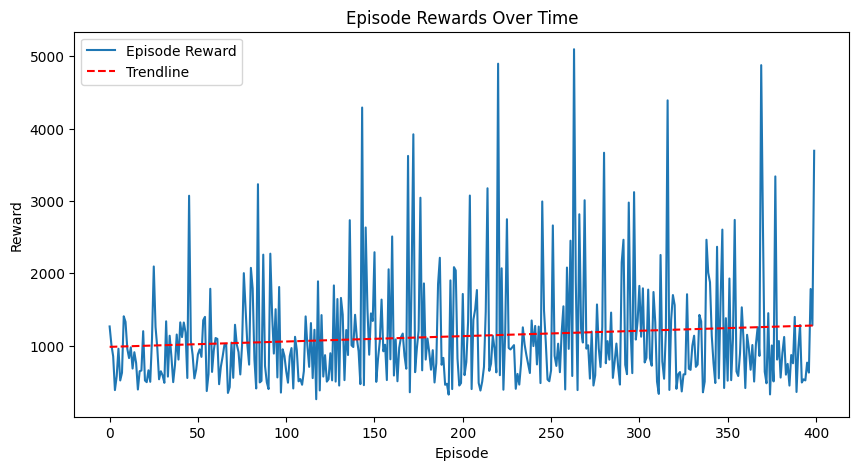

In [3]:
import matplotlib.pyplot as plt

# Plot the episode rewards
plt.figure(figsize=(10, 5))
plt.plot(list_of_episode_rewards, label='Episode Reward')

# Calculate and plot the trendline
x = np.arange(len(list_of_episode_rewards))
z = np.polyfit(x, list_of_episode_rewards, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Time')
plt.legend()
plt.show()

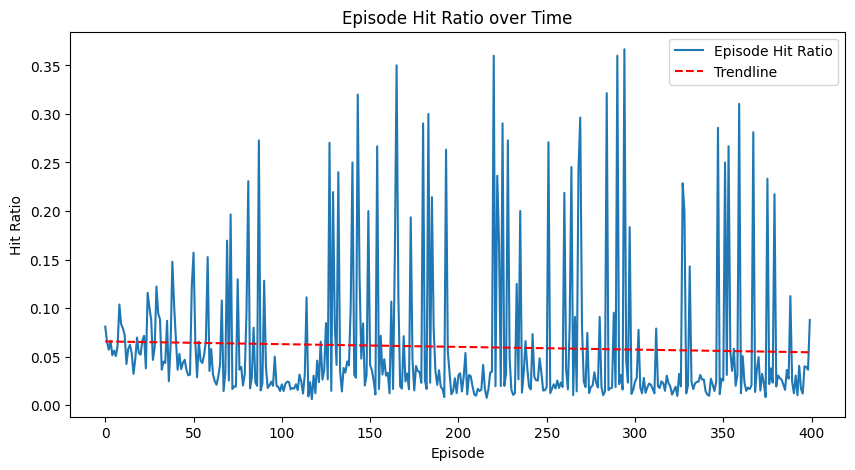

In [4]:
# Plot the episode hit ratio
plt.figure(figsize=(10, 5))
plt.plot(list_of_hit_ratios, label='Episode Hit Ratio')

# Calculate and plot the trendline
x = np.arange(len(list_of_hit_ratios))
z = np.polyfit(x, list_of_hit_ratios, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Hit Ratio')
plt.title('Episode Hit Ratio over Time')
plt.legend()
plt.show()

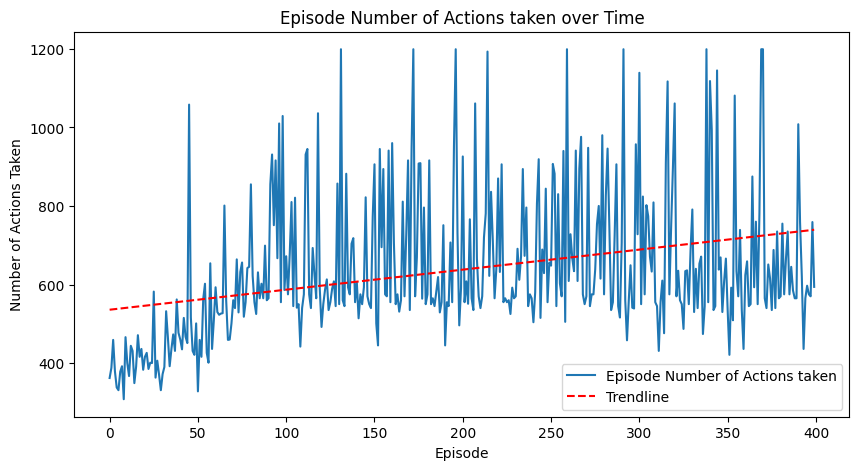

In [5]:
# Plot the episode Actions taken
plt.figure(figsize=(10, 5))
plt.plot(list_of_actions_taken, label='Episode Number of Actions taken')

# Calculate and plot the trendline
x = np.arange(len(list_of_actions_taken))
z = np.polyfit(x, list_of_actions_taken, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trendline')

plt.xlabel('Episode')
plt.ylabel('Number of Actions Taken')
plt.title('Episode Number of Actions taken over Time')
plt.legend()
plt.show()